#COVID-19 행위기반 안전도 산출 및 응용
안녕하세요. 저희는 이번 대회에서 코로나 시대 국민들의 안전한 이동을 돕기위해서 데이터 예측이 아닌 분석에 중점을 두어, **'행위'**를 기반으로 각 건물 별 **안전도**를 평가하고, 이를 이용한 Application으로 길찾기와 장소추천을 생각해보았습니다. 

사용한 외부데이터 및 API:


*   서울시 주민등록인구 (연령별/동별) 통계 2020년 1/4 분기(공공데이터) http://data.seoul.go.kr/dataList/10727/S/2/datasetView.do
*   서울시 주민등록인구 (연령별/구별) 통계 2020년 1/4 분기(공공데이터) http://data.seoul.go.kr/dataList/10718/S/2/datasetView.do
*   서울시 주민등록인구 (성별/구별) 통계 2020년 1/4분기 (공공데이터) http://data.seoul.go.kr/dataList/419/S/2/datasetView.do
*   한국 주민등록인구 (시별) 통계 2020년 3월 (KOSIS) http://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B040A3&conn_path=I2
*   SKT에서 제공하는 서울시 동 중심 좌표 데이터 :  https://www.bigdatahub.co.kr/product/view.do?pid=1000907 (비상업적 목적으로 사용 가능)
*   소상공인시장진흥공단_상가(상권)정보_서울 https://www.data.go.kr/data/15059995/fileData.do
*   서울특별시 병원 인허가 정보  https://data.seoul.go.kr/dataList/OA-16479/S/1/datasetView.do 
*   서울특별시_성동구_종교시설현황 https://www.data.go.kr/data/15032591/fileData.do
*   국토교통부 V World geo coder API http://www.vworld.kr/dev/v4dv_geocoderguide2_s001.do
*    OSRM API http://project-osrm.org/





목차 

0. Package Install 및 Import
1. Covid 19 분석 및 시각화

    1.1 데이터 전처리

    1.2 COVID19 시각화

    1.3 COVID 19 카테고리 분석

2. 안전도 산출

    2.1 데이터 전처리
    
    2.2 안전도 계산

    2.3 안전도 분석

    2.4 안전도 시각화

Application 1: 안전도 길 찾기 

Application 2: 안전도 기반 장소추천

결론

## Package Install 및 Import 
사용환경 : Google colab pro

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install geopandas
!pip install haversine

In [1]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import requests
import json
import datetime
import folium
import time
import geopandas as gpd
from folium import plugins
from branca.element import Template, MacroElement
from pyproj import Transformer
from tqdm import tqdm
#구모 양인 지구 위에서의 최단 거리를 구하기 위해서는 Haversine Formula를 써야 합니다.
from haversine import haversine
#font 설치 (Font 설치 후 반드시 런타임 다시실행할 것 (Crtl+M))
%config InlineBackend.figure_format = 'retina' 
!apt -qq -y install fonts-nanum
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
%matplotlib inline

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.


## 1. Covid 19 분석 및 시각화

###1-1. 데이터 전처리

#### 서울시 인구 전처리

In [2]:
#서울시 주민등록인구 (연령별/동별) 통계 2020년 1/4 분기(공공데이터) http://data.seoul.go.kr/dataList/10727/S/2/datasetView.do
seoul_age= pd.DataFrame(pd.read_csv('/content/drive/My Drive/hakerton/COVID_19/Seoul_age.txt', sep='\t'))
#서울시 주민등록인구 (연령별/구별) 통계 2020년 1/4 분기(공공데이터) http://data.seoul.go.kr/dataList/10718/S/2/datasetView.do
seoul_age_gu =pd.DataFrame(pd.read_csv('/content/drive/My Drive/hakerton/COVID_19/Seoul_age(gu).txt', sep='\t'))
#서울시 주민등록인구 (성별/구별) 통계 2020년 1/4분기 (공공데이터) http://data.seoul.go.kr/dataList/419/S/2/datasetView.do
seoul_sex = pd.DataFrame(pd.read_csv('/content/drive/My Drive/hakerton/COVID_19/Seoul_sex(gu).txt', sep='\t'))
#한국 주민등록인구 (시별) 통계 2020년 3월 (KOSIS) http://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B040A3&conn_path=I2
korea_age = pd.DataFrame(pd.read_excel('/content/drive/My Drive/hakerton/COVID_19/korea_age.xlsx'))

In [3]:
#서울시 전체 연령대별 인구 파악을 위한 전처리
seoul_age_total = seoul_age.iloc[0,:]                                           #전체 통계 가져옴
seoul_age_total = pd.DataFrame(seoul_age_total)                                 #dataFrame으로 변환
seoul_age_total.drop(['기간','자치구','동','구분','계'],axis=0,inplace=True)    #필요없는 부분 drop
seoul_age_total= seoul_age_total.reset_index().rename(columns={"index": "age"}) #index를 가져옴
seoul_age_total.columns = ['age','counts']                                      #열 이름 재설정

#자리수 구분을 위한 ','가 str이라서 정수로 만들어줌
seoul_age_total['counts_1'] = seoul_age_total.counts.str.split(',').str[0]
seoul_age_total['counts_2'] = seoul_age_total.counts.str.split(',').str[1]
seoul_age_total['counts'] = seoul_age_total[['counts_1','counts_2']].apply(lambda x:''.join(x),axis=1)
seoul_age_total['counts'] = seoul_age_total['counts'].astype(int)
seoul_age_total.drop(['counts_1','counts_2'],axis=1,inplace=True)

In [4]:
#나이가 5세단위로 묶여 있어서, 10세단위로 묶어줌 (코로나 데이터가 10세단위라 비교하기 위해서)
#!! Covid19에 100세 이상은 따로 표기가 안되기 때문에, 마찬가지로 90대 이상으로 묶음
seoul_age_total['age'].replace(
    to_replace=list(seoul_age_total['age'].unique()),
    value=['0s', '0s', '10s', '10s', '20s', '20s', '30s','30s', '40s', '40s', '50s', '50s', '60s','60s', '70s', '70s', '80s','80s','90s','90s','90s'],
    inplace=True)

In [5]:
#연령대별로 통계를 내준 뒤, 인덱스 정렬
seoul_age_total = (seoul_age_total.groupby('age').sum().reset_index().rename(columns={"index": "age"})).sort_values(by=['age'], axis=0)
seoul_age_total['counts'] = (seoul_age_total['counts'] / seoul_age_total['counts'].sum()) * 100

In [6]:
#서울시 전체 남성/ 여성 인구 집계
seoul_sex_whole = seoul_sex.iloc[0:3,0:6]
seoul_sex_whole.drop(['기간','자치구','세대','인구'],axis=1,inplace=True)
seoul_sex_whole.drop([0,1],axis=0,inplace=True)
seoul_sex_whole.reset_index(drop=True,inplace=True)
seoul_sex_whole.columns=['남자','여자']
seoul_sex_whole=seoul_sex_whole.T.reset_index()
seoul_sex_whole.columns=['sex','counts']
#counts int로 만들어주기
seoul_sex_whole['counts_1'] = seoul_sex_whole.counts.str.split(',').str[0]
seoul_sex_whole['counts_2'] = seoul_sex_whole.counts.str.split(',').str[1]
seoul_sex_whole['counts_3'] = seoul_sex_whole.counts.str.split(',').str[2]
seoul_sex_whole['counts'] = seoul_sex_whole[['counts_1','counts_2','counts_3']].apply(lambda x:''.join(x),axis=1)
seoul_sex_whole['counts'] = seoul_sex_whole['counts'].astype(int)
seoul_sex_whole.drop(['counts_1','counts_2','counts_3'],axis=1,inplace=True)
# 비율(%)로 나타내기
seoul_sex_whole['counts'] = (seoul_sex_whole['counts'] / seoul_sex_whole['counts'].sum()) * 100

#### 한국 인구 전처리

In [7]:
korea_age.columns=('행정구역(시군구)별','총인구수 (명)','남자인구수 (명)','여자인구수 (명)')
#성별 한국 인구
korea_age_sex = pd.DataFrame(korea_age.loc[1,['남자인구수 (명)', '여자인구수 (명)']])
korea_age_sex = korea_age_sex.reset_index()
korea_age_sex.columns = ['sex','counts']
korea_age_sex['counts'] = korea_age_sex['counts']/korea_age_sex['counts'].sum() * 100 
korea_age_sex.set_index('sex',inplace=True)

In [8]:
#지역별 한국인구
korea_province = pd.DataFrame(korea_age.drop([0,1], axis=0))
korea_province['총인구수 (명)'] = (korea_province['총인구수 (명)'] / korea_age.loc[1,'총인구수 (명)']) *100

#### 서울시 유동인구 데이터 전처리

In [9]:
adstrd_master_file = '/content/drive/My Drive/hakerton/fpopl_2020/adstrd_master.csv'                #코드 마스터 파일
fpopl_2020_file='/content/drive/My Drive/hakerton/fpopl_2020/fpopl_2020.csv'                        #유동인구 파일
adstrd_master = pd.read_csv(adstrd_master_file, sep=',')
fpopl_2020= pd.read_csv(fpopl_2020_file, sep=',')
adstrd=pd.DataFrame(adstrd_master)
fpopl = pd.DataFrame(fpopl_2020)
adstrd=adstrd[adstrd['brtc_nm'] == '서울특별시']
yudong = fpopl.merge(adstrd,on='adstrd_code', how='outer')       #병합

In [10]:
# data from SKT :  https://www.bigdatahub.co.kr/product/view.do?pid=1000907 , SKT에서 제공하는 동 좌표 데이터 (비상업적 목적으로 사용 가능)
appKey = 'f3ccf85987433913c6a21ed75212751865bca2a360843292835d7e6d4cf8678a'
url = 'https://api.bigdatahub.co.kr/v1/datahub/datasets/search.json?pid=1000907'
params = {'TDCAccessKey': appKey,'$page':1,'$count':500} 
res = requests.get(url, params=params)
print(res.status_code)

200


In [11]:
locdata = res.json()
locdata=pd.DataFrame(locdata['entry'])
del locdata['시']
del locdata['구']
locdata.columns=['adstrd_nm','longitude','latitude']
#누락된 데이터 수기로 추가함, 기존데이터와 이름 맞춰줌 면목3.8동 -> 면목제3.8동
locdata.loc[423] = {'adstrd_nm': '항동','longitude':'126.8236562','latitude':'37.4810222'}
locdata.iloc[99, 0] = '면목제3.8동'
locdata.loc[424] = {'adstrd_nm' : '위례동', 'longitude': '127.141418', 'latitude' : '37.479289'}

In [12]:
yudong_map = yudong.merge(locdata, on='adstrd_nm', how='outer') #병합

In [13]:
#tmzon_se_code의 0, 1, 2 ...등을 0000 0100 0200 등으로 변경
yudong_map['tmzon_se_code']= yudong_map['tmzon_se_code'].replace({0:'0000',1:'0100',2:'0200',3:'0300',4:'0400',5:'0500',6:'0600',7:'0700',8:'0800',9:'0900',10:'1000',
                                                                  11:'1100',12:'1200',13:'1300',14:'1400',15:'1500',16:'1600',17:'1700',18:'1800',19:'1900',20:'2000',
                                                                  21:'2100',22:'2200',23:'2300'})

#베이스 년도 int형태로 변환 (날짜별로 필터링하기 위해서)
yudong_map['base_ymd'] = yudong_map['base_ymd'].astype(int)

#3월4일(평일)데이터, 3월7일(주말)데이터 추출
yudong_wk = yudong_map.drop(yudong_map.loc[yudong_map['base_ymd']!=20200304].index)
yudong_wknd = yudong_map.drop(yudong_map.loc[yudong_map['base_ymd']!=20200307].index)

#타입 str로 변경
yudong_wk['tmzon_se_code'] = yudong_wk['tmzon_se_code'].astype(str)
yudong_wk['base_ymd'] = yudong_wk['base_ymd'].astype(str)
yudong_wknd['tmzon_se_code'] = yudong_wknd['tmzon_se_code'].astype(str)
yudong_wknd['base_ymd'] = yudong_wknd['base_ymd'].astype(str)

#새로운 time 컬럼에 시간 병합
yudong_wk['time'] = yudong_wk[['base_ymd','tmzon_se_code']].apply(lambda x:' '.join(x),axis=1)
yudong_wknd['time'] = yudong_wknd[['base_ymd','tmzon_se_code']].apply(lambda x:' '.join(x),axis=1)

#시간데이터로 변환
yudong_wk['time'] = pd.to_datetime(yudong_wk['time'])
yudong_wknd['time'] = pd.to_datetime(yudong_wknd['time'])

#time을 index로 설정
yudong_wk = yudong_wk.set_index('time')
yudong_wknd = yudong_wknd.set_index('time')

In [14]:
#1 시각화 하기 위해 필요 정보 pivot table로 추출
pivot_wk = yudong_wk.pivot_table('popltn_cascnt', index=['adstrd_nm','latitude', 'longitude', 'sexdstn_se_code', yudong_wk.index]).reset_index()
pivot_wknd = yudong_wknd.pivot_table('popltn_cascnt', index=['adstrd_nm','latitude', 'longitude', 'sexdstn_se_code', yudong_wknd.index]).reset_index()

#남여 데이터 분리
male_pivot_wk = pivot_wk.drop(pivot_wk.loc[pivot_wk['sexdstn_se_code']!='M'].index)
female_pivot_wk = pivot_wk.drop(pivot_wk.loc[pivot_wk['sexdstn_se_code']!='F'].index)
male_pivot_wknd = pivot_wknd.drop(pivot_wknd.loc[pivot_wknd['sexdstn_se_code']!='M'].index)
female_pivot_wknd = pivot_wknd.drop(pivot_wknd.loc[pivot_wknd['sexdstn_se_code']!='F'].index)

#type 변경
male_pivot_wk['popltn_cascnt']=male_pivot_wk['popltn_cascnt'].astype(int)
female_pivot_wk['popltn_cascnt']=female_pivot_wk['popltn_cascnt'].astype(int)
male_pivot_wknd['popltn_cascnt']=male_pivot_wknd['popltn_cascnt'].astype(int)
female_pivot_wknd['popltn_cascnt']=female_pivot_wknd['popltn_cascnt'].astype(int)

In [15]:
#색 지정
male_pivot_wk['fillColor'] = '#5357c6'
male_pivot_wk.loc[male_pivot_wk['popltn_cascnt']<1500 , 'fillColor'] = '#5389c6'
male_pivot_wk.loc[male_pivot_wk['popltn_cascnt']<1000 , 'fillColor'] = '#53b9c6'
male_pivot_wk.loc[male_pivot_wk['popltn_cascnt']<500 , 'fillColor'] = '#93bec2'
male_pivot_wk.loc[male_pivot_wk['popltn_cascnt']<250 , 'fillColor'] = '#586065'

female_pivot_wk['fillColor'] = '#c65366'
female_pivot_wk.loc[female_pivot_wk['popltn_cascnt']<1500 , 'fillColor'] = '#c65381'
female_pivot_wk.loc[female_pivot_wk['popltn_cascnt']<1000 , 'fillColor'] = '#c653b7'
female_pivot_wk.loc[female_pivot_wk['popltn_cascnt']<500 , 'fillColor'] = '#c293b5'
female_pivot_wk.loc[female_pivot_wk['popltn_cascnt']<250 , 'fillColor'] = '#586065'

male_pivot_wknd['fillColor'] = '#5357c6'
male_pivot_wknd.loc[male_pivot_wknd['popltn_cascnt']<1500 , 'fillColor'] = '#5389c6'
male_pivot_wknd.loc[male_pivot_wknd['popltn_cascnt']<1000 , 'fillColor'] = '#53b9c6'
male_pivot_wknd.loc[male_pivot_wknd['popltn_cascnt']<500 , 'fillColor'] = '#93bec2'
male_pivot_wknd.loc[male_pivot_wknd['popltn_cascnt']<250 , 'fillColor'] = '#586065'

female_pivot_wknd['fillColor'] = '#c65366'
female_pivot_wknd.loc[female_pivot_wknd['popltn_cascnt']<1500 , 'fillColor'] = '#c65381'
female_pivot_wknd.loc[female_pivot_wknd['popltn_cascnt']<1000 , 'fillColor'] = '#c653b7'
female_pivot_wknd.loc[female_pivot_wknd['popltn_cascnt']<500 , 'fillColor'] = '#c293b5'
female_pivot_wknd.loc[female_pivot_wknd['popltn_cascnt']<250 , 'fillColor'] = '#586065'

In [16]:
#json data 생성 함수 (성별 구분)
def create_geojson_features (df):
    features = []
    
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry' : {
                'type':'Point',
                'coordinates':[float(row['longitude']),float(row['latitude'])]
            },
            'properties': {
                'time' : pd.to_datetime(row['time'],unit='h').__str__(),
                'style' : {'color':''},
                'icon' : 'circle',
                'sex' : row['sexdstn_se_code'],
                'iconstyle':{
                    'fillColor': row['fillColor'],
                    'fillOpacity': 0.6,
                    'stroke' : 'true',
                    'radius': row['popltn_cascnt'] * 0.05
                }
            }
        }
        features.append(feature)
    return features

#### Covid 19 (1.20~ 6.30) 데이터 전처리

In [17]:
covid_info=pd.DataFrame(pd.read_csv('/content/drive/My Drive/hakerton/COVID_19/PatientInfo.csv',sep=','))
covid_case = pd.DataFrame(pd.read_csv("/content/drive/My Drive/hakerton/COVID_19/Case.csv",sep=','))

###1-2. COVID 19 시각화

#### 케이스 별 감염자 수 

In [18]:
covid_wholecase_count =pd.DataFrame((covid_case['confirmed'].groupby(covid_case['infection_case'])).sum())
covid_wholecase_count.reset_index(inplace=True)
covid_wholecase_count['confirmed'] = (covid_wholecase_count['confirmed'] / covid_wholecase_count['confirmed'].sum()) * 100
covid_wholecase_count.sort_values(by=['confirmed'], axis=0, ascending=False, inplace=True)
covid_wholecase_count.reset_index(drop=True, inplace=True)

In [19]:
covid_wholecase_count.loc[covid_wholecase_count["infection_case"] == "Shincheonji Church", "infection_case"] = "신천지 교회"
covid_wholecase_count.loc[covid_wholecase_count["infection_case"] == "contact with patient", "infection_case"] = "환자와 직접 접촉"
covid_wholecase_count.loc[covid_wholecase_count["infection_case"] == "overseas inflow", "infection_case"] = "해외 유입"
covid_wholecase_count.loc[covid_wholecase_count["infection_case"] == "Itaewon Clubs", "infection_case"] = "이태원 클럽"
covid_wholecase_count.loc[covid_wholecase_count["infection_case"] == "Second Mi-Ju Hospital", "infection_case"] = "제 2 미주 병원"
covid_wholecase_count.loc[covid_wholecase_count["infection_case"] == "Richway", "infection_case"] = "Richway (다단계)"
covid_wholecase_count.loc[covid_wholecase_count["infection_case"] == "Guro-gu Call Center", "infection_case"] = "구로구 콜센터"
covid_wholecase_count.loc[covid_wholecase_count["infection_case"] == "Coupang Logistics Center", "infection_case"] = "쿠팡 물류센터"
covid_wholecase_count.loc[covid_wholecase_count["infection_case"] == "Hansarang Convalescent Hospital", "infection_case"] = "한사랑 요양 병원"

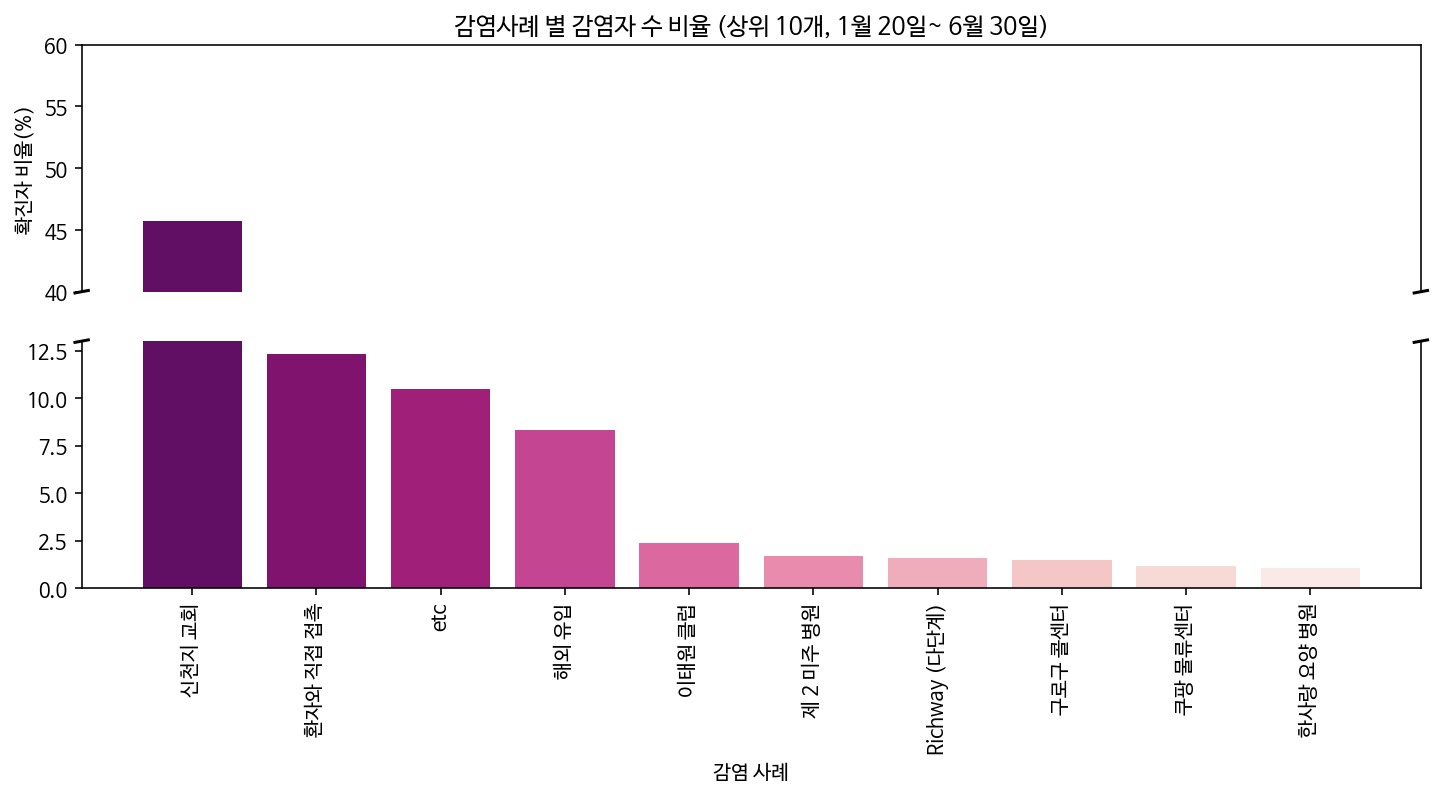

In [20]:
figure,((ax,ax2)) = plt.subplots(nrows=2, ncols=1, sharex=True)
figure.set_size_inches(12,5)
sequential_colors = sns.color_palette("RdPu_r", 10)
sns.set_palette(sequential_colors)
sns.barplot(data=covid_wholecase_count.loc[:9], x="infection_case", y="confirmed", ax=ax)
sns.barplot(data=covid_wholecase_count.loc[:9], x="infection_case", y="confirmed", ax=ax2)
ax.set_ylim(40,60)
ax2.set_ylim(0, 13)
ax.xaxis.set_visible(False)
plt.ylabel('')
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .005  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax.set(title="감염사례 별 감염자 수 비율 (상위 10개, 1월 20일~ 6월 30일)",ylabel='확진자 비율(%)')
ax2.set(xlabel="감염 사례")
plt.xticks(rotation=90)
plt.savefig('case.png',dpi=250, transparent=True, bbox_inches= "tight")
plt.show()

케이스별로는 신천지 관련 코로나 19 환자가 압도적으로 많았고 (약 45%) 환자와 직접 접촉(약 12.5%), 기타(약 10%), 해외유입(약 8%) 등이 뒤를 이었습니다. (전체의 약 75%) 

다음으로는 개별 감염 이외에 집단 감염 사례만 추출해보았습니다.

In [21]:
#집단 감염 사례 추출
covid_wholecase_count_group = covid_case[covid_case['group'] == True].copy()
covid_wholecase_count_group.drop([' case_id','province','city','group','latitude','longitude'],axis=1,inplace=True)
covid_wholecase_count_group= pd.DataFrame((covid_wholecase_count_group['confirmed'].groupby(covid_wholecase_count_group['infection_case'])).sum()) #코로나 확진자 수를 케이스별로 통합
covid_wholecase_count_group.reset_index(inplace=True)
covid_wholecase_count_group['confirmed'] = (covid_wholecase_count_group['confirmed'] / covid_wholecase_count_group['confirmed'].sum()) * 100 # %로 표기
covid_wholecase_count_group.sort_values(by=['confirmed'], axis=0, ascending=False, inplace=True)
covid_wholecase_count_group.reset_index(drop=True, inplace=True)

In [22]:
covid_wholecase_count_group.loc[covid_wholecase_count_group["infection_case"] == "Shincheonji Church", "infection_case"] = "신천지 교회"
covid_wholecase_count_group.loc[covid_wholecase_count_group["infection_case"] == "Cheongdo Daenam Hospital", "infection_case"] = "청도 대남 병원"
covid_wholecase_count_group.loc[covid_wholecase_count_group["infection_case"] == "gym facility in Cheonan", "infection_case"] = "천안 운동시설"
covid_wholecase_count_group.loc[covid_wholecase_count_group["infection_case"] == "Itaewon Clubs", "infection_case"] = "이태원 클럽"
covid_wholecase_count_group.loc[covid_wholecase_count_group["infection_case"] == "Daesil Convalescent Hospital", "infection_case"] = "대실 요양 병원"
covid_wholecase_count_group.loc[covid_wholecase_count_group["infection_case"] == "Second Mi-Ju Hospital", "infection_case"] = "제 2 미주 병원"
covid_wholecase_count_group.loc[covid_wholecase_count_group["infection_case"] == "Richway", "infection_case"] = "Richway (다단계)"
covid_wholecase_count_group.loc[covid_wholecase_count_group["infection_case"] == "Guro-gu Call Center", "infection_case"] = "구로구 콜센터"
covid_wholecase_count_group.loc[covid_wholecase_count_group["infection_case"] == "Coupang Logistics Center", "infection_case"] = "쿠팡 물류센터"
covid_wholecase_count_group.loc[covid_wholecase_count_group["infection_case"] == "Hansarang Convalescent Hospital", "infection_case"] = "한사랑 요양 병원"

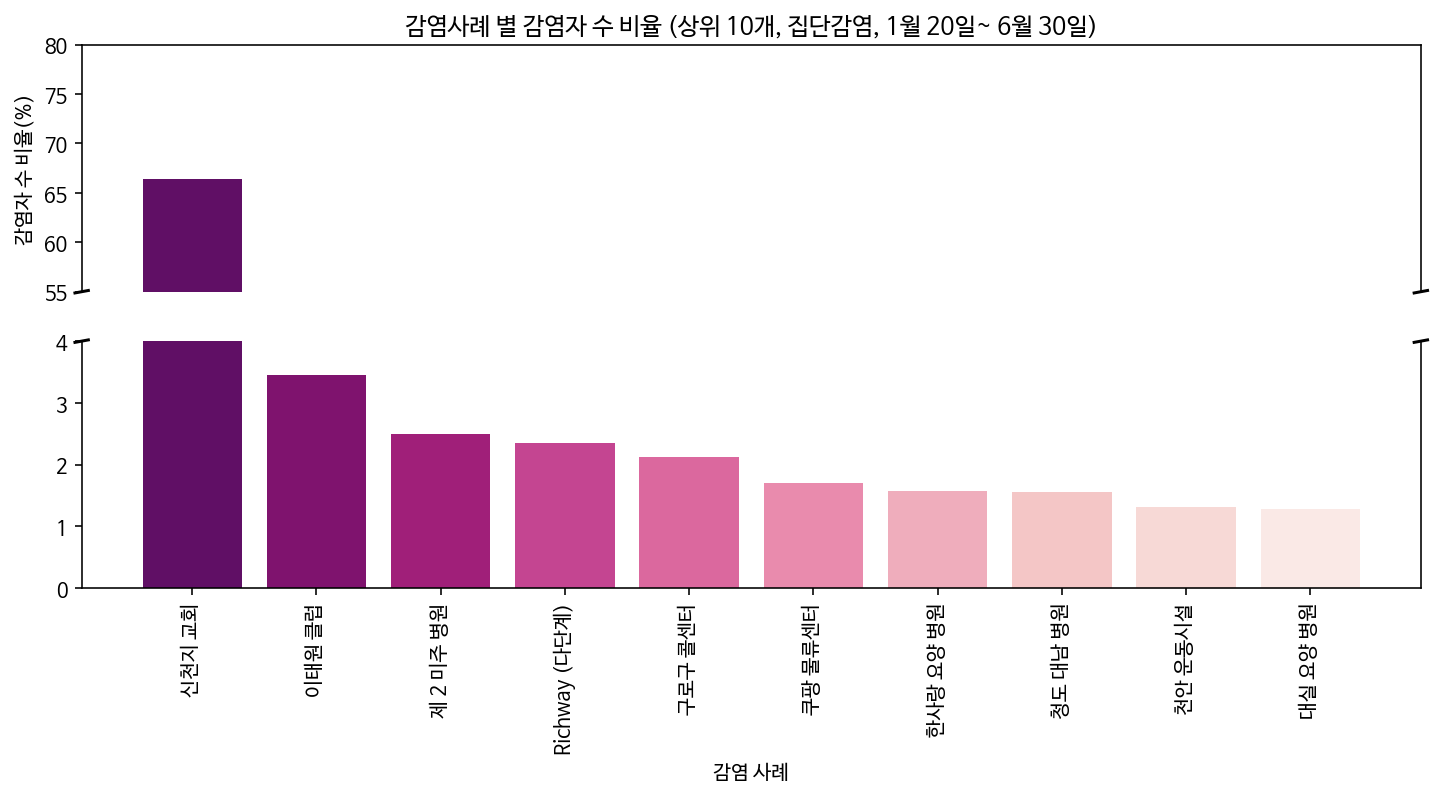

In [23]:
figure,((ax,ax2)) = plt.subplots(nrows=2, ncols=1, sharex=True)
figure.set_size_inches(12,5)
sns.barplot(data=covid_wholecase_count_group.loc[:9], x="infection_case", y="confirmed", ax=ax)
sns.barplot(data=covid_wholecase_count_group.loc[:9], x="infection_case", y="confirmed", ax=ax2)
sequential_colors = sns.color_palette("BuPu_r", 10)
sns.set_palette(sequential_colors)

ax.set_ylim(55,80)
ax2.set_ylim(0, 4)
ax.xaxis.set_visible(False)
plt.ylabel('')
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .005  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax.set(title="감염사례 별 감염자 수 비율 (상위 10개, 집단감염, 1월 20일~ 6월 30일)",xlabel="감염 사례", ylabel='감염자 수 비율(%)')
ax2.set(xlabel="감염 사례")
plt.xticks(rotation=90)
plt.savefig('groupcase.png',dpi=250, transparent=True, bbox_inches= "tight")
plt.show()

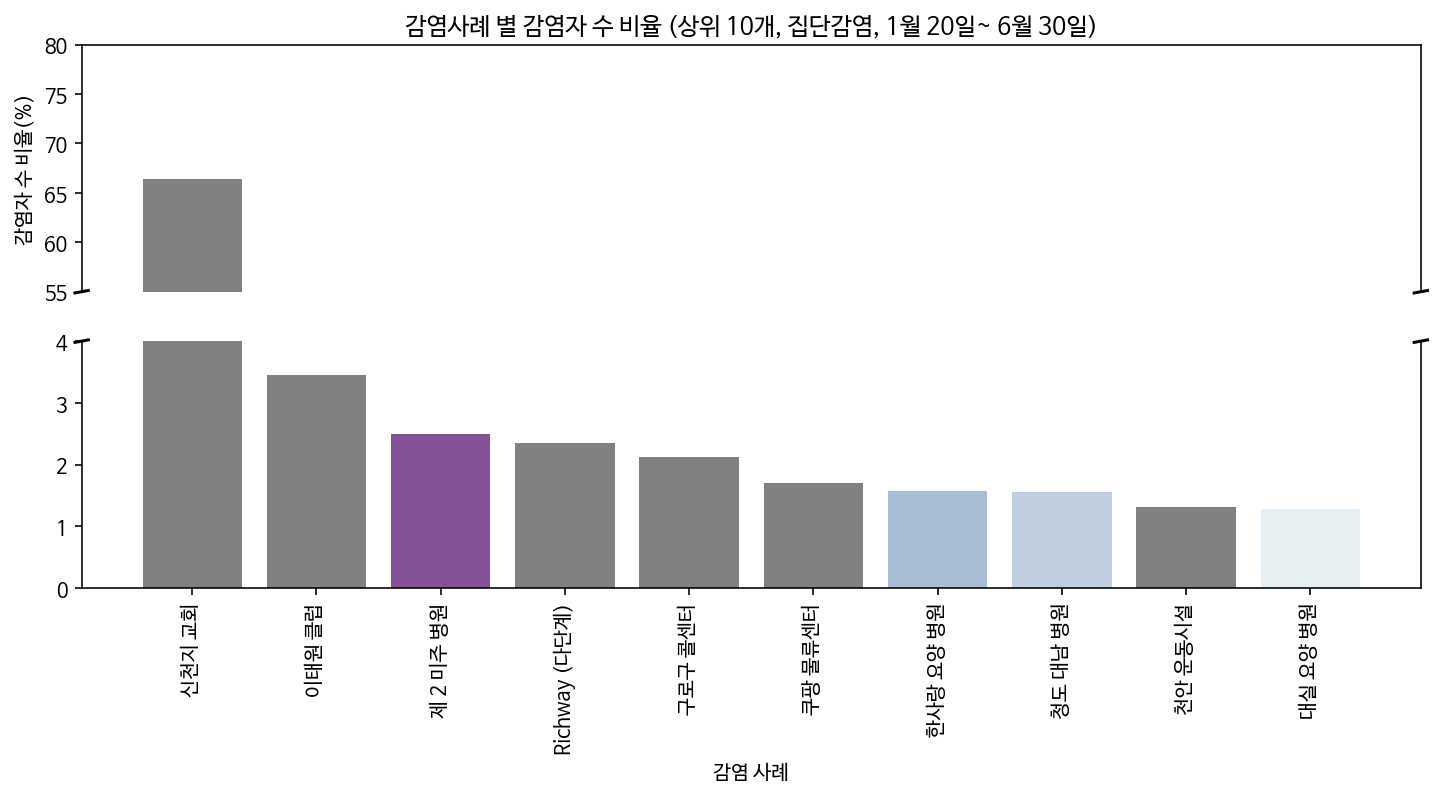

In [24]:
figure,((ax,ax2)) = plt.subplots(nrows=2, ncols=1, sharex=True)
figure.set_size_inches(12,5)

sequential_colors = sns.color_palette("BuPu_r", 10)
custom_colors = ['grey', 'grey',sequential_colors[2],'grey','grey','grey',sequential_colors[6],sequential_colors[7],'grey',sequential_colors[9]]
sns.set_palette(custom_colors)

sns.barplot(data=covid_wholecase_count_group.loc[:9], x="infection_case", y="confirmed", ax=ax)
sns.barplot(data=covid_wholecase_count_group.loc[:9], x="infection_case", y="confirmed", ax=ax2)
ax.set_ylim(55,80)
ax2.set_ylim(0, 4)
ax.xaxis.set_visible(False)
plt.ylabel('')
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .005  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax.set(title="감염사례 별 감염자 수 비율 (상위 10개, 집단감염, 1월 20일~ 6월 30일)",xlabel="감염 사례", ylabel='감염자 수 비율(%)')
ax2.set(xlabel="감염 사례")
plt.xticks(rotation=90)
plt.savefig('groupcase_hos.png',dpi=250, transparent=True, bbox_inches= "tight")
plt.show()

집단 감염사례로는 신천지 교회가 역시 가장 많았고(집단감염 사례의 약 65%), 이태원 클럽 (약 3.5%), 제2 미주병원(약 2.5%), 리치웨이(다단계, 약 2%), 구로콜센터(약 2%) 등이 뒤를 이었습니다.

##### 서울시 감염 케이스 별 감염자 수

In [25]:
covid_case_seoul= covid_case[covid_case['province'] == '서울'].copy() #서울시 데이터만
covid_case_seoul.sort_values(by=['confirmed'], axis=0, ascending=False, inplace=True)
covid_case_seoul['confirmed'] = (covid_case_seoul['confirmed'] / covid_case_seoul['confirmed'].sum()) *100 
covid_case_seoul.reset_index(inplace=True, drop=True)

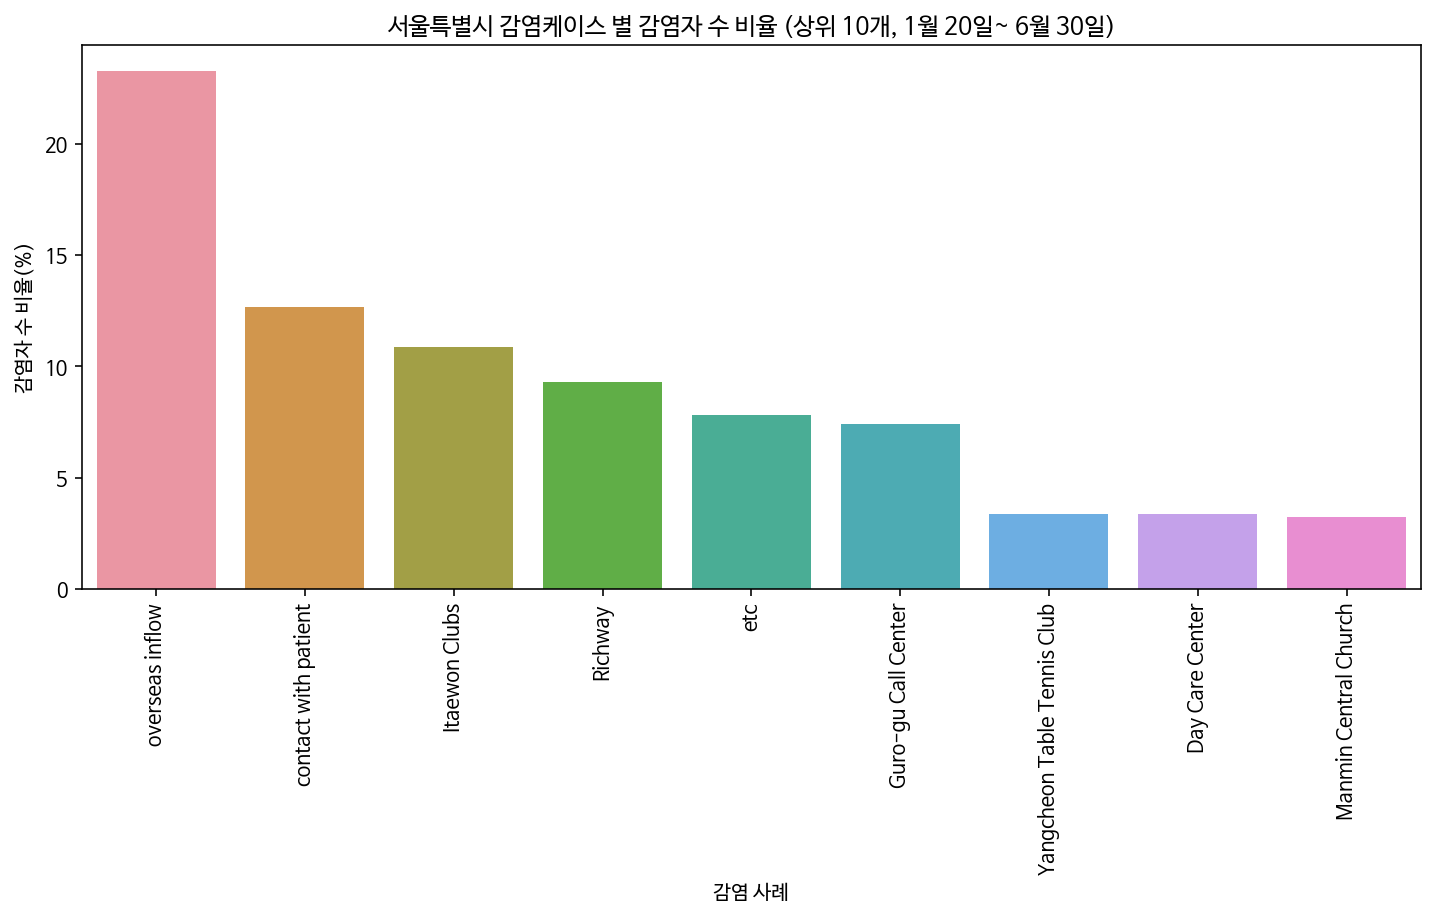

In [26]:
figure, ((ax)) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(12,5)
sns.set_palette("Accent")
sns.barplot(data=covid_case_seoul[:9], x="infection_case", y="confirmed", ax=ax)
ax.set(title="서울특별시 감염케이스 별 감염자 수 비율 (상위 10개, 1월 20일~ 6월 30일)",xlabel="감염 사례", ylabel='감염자 수 비율(%)')
plt.xticks(rotation=90)
plt.show()

서울특별시의 경우 해외유입자 (약 25%), 환자와 직접접촉(약 13%), 이태원 클럽 (약 10%), Richway(약 10%) 순으로 감염자 수가 많았습니다.

In [27]:
covid_case_seoul_group = covid_case_seoul[covid_case_seoul['group']==True].copy()
covid_case_seoul_group.sort_values(by=['confirmed'], axis=0, ascending=False, inplace=True)
covid_case_seoul_group['confirmed'] = (covid_case_seoul_group['confirmed'] / covid_case_seoul_group['confirmed'].sum()) *100 
covid_case_seoul_group.reset_index(inplace=True, drop=True)

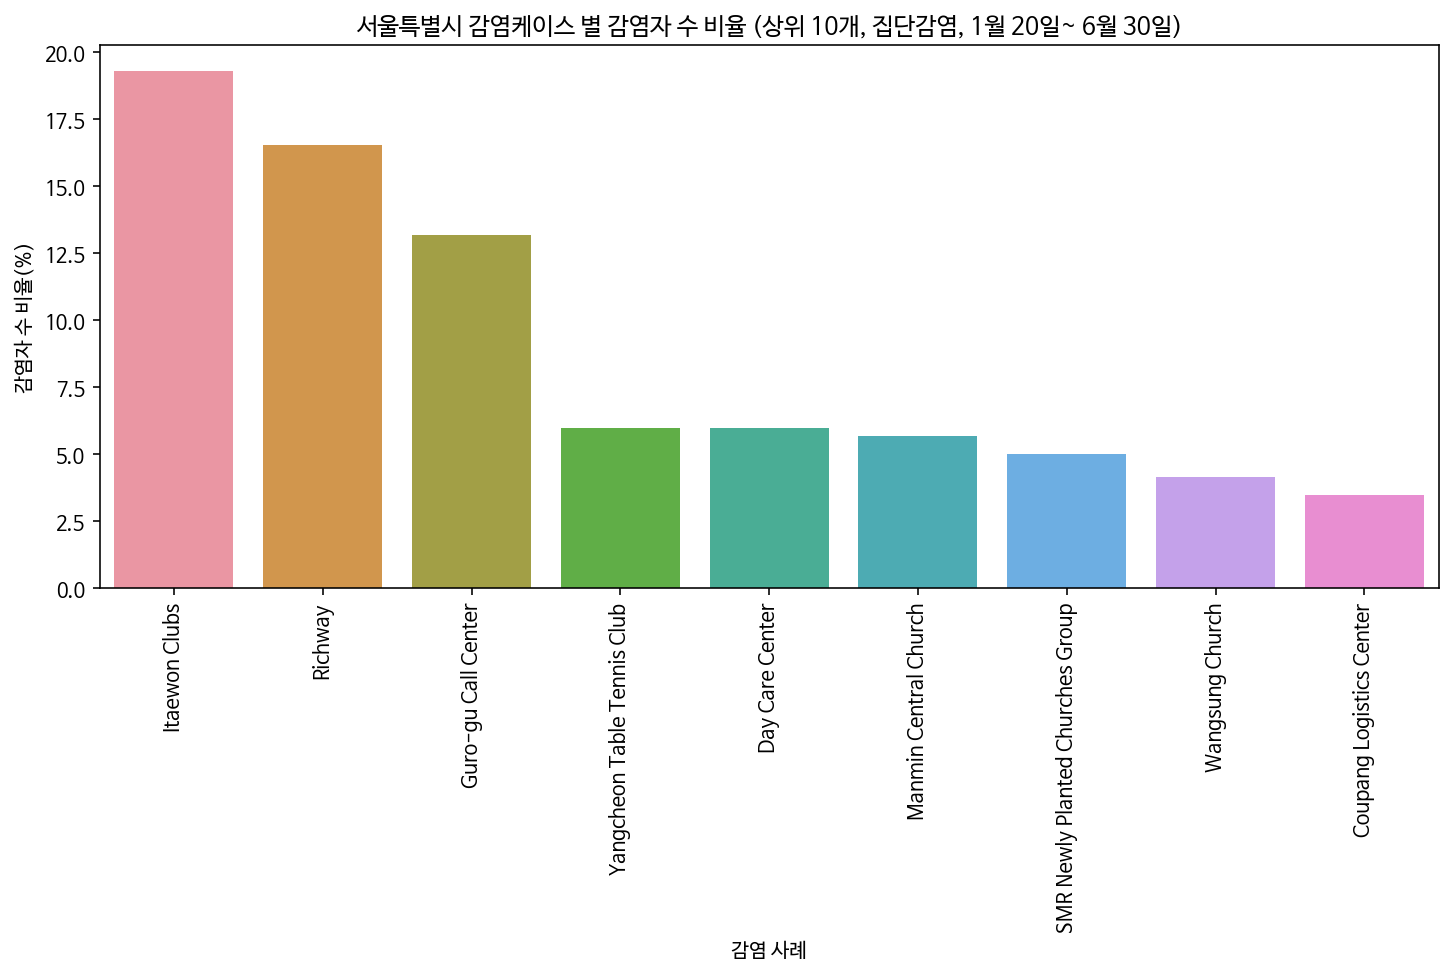

In [28]:
figure, ((ax)) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(12,5)
sns.set_palette("Accent")
sns.barplot(data=covid_case_seoul_group[:9], x="infection_case", y="confirmed", ax=ax)
ax.set(title="서울특별시 감염케이스 별 감염자 수 비율 (상위 10개, 집단감염, 1월 20일~ 6월 30일)",xlabel="감염 사례", ylabel='감염자 수 비율(%)')
plt.xticks(rotation=90)
plt.show()

서울특별시의 집단감염 케이스 중에서는 이태원 클럽이 가장 많았고 (약 19%), 다음 Richway (16%), 구로구콜센터 (약 12.5%), 양천 탁구클럽(5%) 등이 뒤를 이었습니다.

##### 서울시 성별 코로나 확진자수 비교 

In [29]:
#서울시 코로나 정보 
info_seoul = covid_info[covid_info['province'] == '서울'].copy()
#감염자 성별 데이터 추출
covid_seoul_sex=pd.DataFrame(info_seoul['sex'].value_counts()).reset_index().rename(columns={"index": "sex"})
covid_seoul_sex.columns=['sex','counts']
covid_seoul_sex.sort_values(by=['counts'], axis=0, ascending=True, inplace=True)
covid_seoul_sex.iloc[0,0] = "남자" 
covid_seoul_sex.iloc[1,0] = "여자"
covid_seoul_sex['counts'] = covid_seoul_sex['counts'] / covid_seoul_sex['counts'].sum() *100

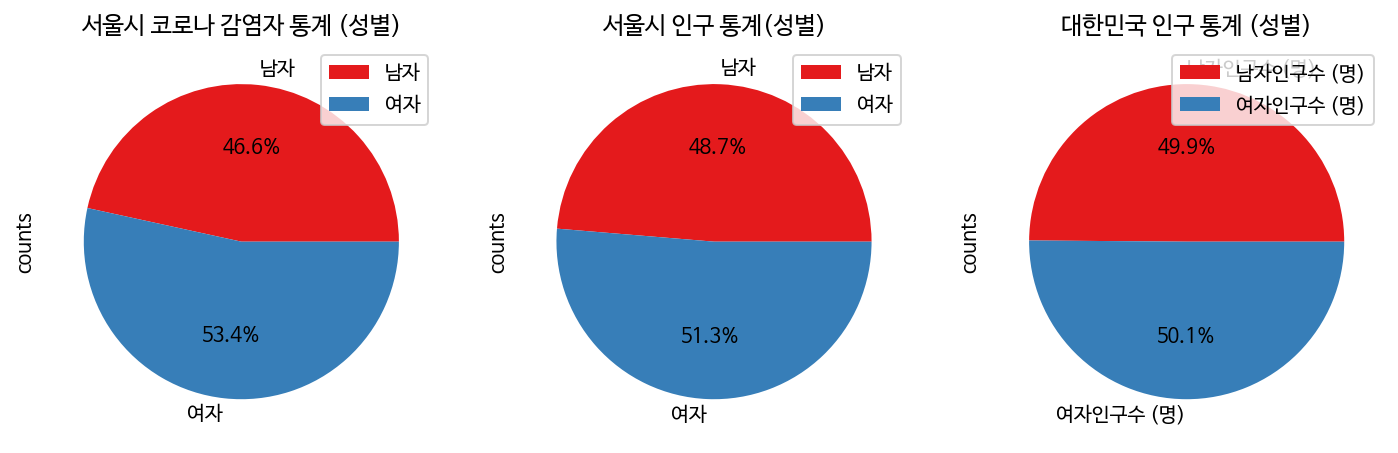

In [30]:
#파이차트 시각화
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(12,5)
sns.set_palette("Set1")
covid_seoul_sex_pie = covid_seoul_sex.set_index(covid_seoul_sex['sex'],drop=True)
seoul_sex_whole_pie = seoul_sex_whole.set_index(seoul_sex_whole['sex'],drop=True)
covid_seoul_sex_pie.plot.pie(y='counts',autopct='%1.1f%%',ax=ax1)
seoul_sex_whole_pie.plot.pie(y='counts',autopct='%1.1f%%',ax=ax2)
korea_age_sex.plot.pie(y='counts',autopct='%1.1f%%', ax=ax3)
ax1.set(title="서울시 코로나 감염자 통계 (성별)")
ax2.set(title="서울시 인구 통계(성별)")
ax3.set(title="대한민국 인구 통계 (성별)")
plt.show()

서울시 코로나 감염자의 성별 통계는 서울시 주민등록 인구 성별 통계를 따라가는 모습을 보였습니다.우리나라 전체 성비 통계와는 약간 차이가 있었습니다.



#### 성별에 따른 유동인구 시각화
임의의 날짜 (주중 - 3월 4일, 주말-3월 7일)을 골라 하루동안 서울특별시의 유동인구를 성별에 따라 시각화해봤습니다.

In [31]:
#주간 / 주말 남/녀 유동인구 시각화를 위한 geojson 형식 list 생성
malegeo_wk = create_geojson_features(male_pivot_wk)
femalegeo_wk= create_geojson_features(female_pivot_wk)
malegeo_wknd = create_geojson_features(male_pivot_wknd)
femalegeo_wknd= create_geojson_features(female_pivot_wknd)

주중 (3월4일) 유동인구 시각화

In [32]:
dualmap = plugins.DualMap(location = [37.55, 127],
                 tiles = 'cartodbpositron',
                 zoom_start = 12)


plugins.TimestampedGeoJson(malegeo_wk,
                           period = 'PT1H',
                           duration = 'PT1M',
                           transition_time = 500,
                           auto_play = True, ).add_to(dualmap.m1)

plugins.TimestampedGeoJson(femalegeo_wk,
                           period = 'PT1H',
                           duration = 'PT1M',
                           transition_time = 500,
                           auto_play = True, ).add_to(dualmap.m2)
#TimestampedGeoJson에 Legend기능이 없어 부득이 html로 직접 넣어주었습니다.
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend(male/female)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#5357c6;'></span><span style='background:#c65366;'></span>1500 or more</li>
    <li><span style='background:#5389c6;'></span><span style='background:#c65381;'></span>1000 or more</li>
    <li><span style='background:#53b9c6;'></span><span style='background:#c653b7;'></span>500 or more</li>
    <li><span style='background:#93bec2;'></span><span style='background:#c293b5;'></span>250 or more</li>
    <li><span style='background:#586065;'></span>less than 250</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)
dualmap.get_root().add_child(macro)


dualmap


Output hidden; open in https://colab.research.google.com to view.

1.   서울특별시 등록 인구가 여성이 많은것에 반해, 모든 시간대에 걸쳐 남성 유동인구가 여성의 유동인구보다 많은것을 확인할 수 있었습니다. 

2.   남성과 여성 모두 18:00경 가장 유동인구가 많았습니다. 

3.   강남, 올림픽대로 부근, 종로3가, 서교동(홍대), 가산디지털단지, 이촌동, 성수동 등의 지역의 유동인구가 많았습니다. 특히 가산디지털단지는 남성 유동인구가 더 많았습니다.

4.    남성과 여성 모두 03:00경 유동인구가 가장 적었습니다. 





주말(3월 7일) 유동인구 시각화

In [33]:
dualmap = plugins.DualMap(location = [37.55, 127],
                 tiles = 'cartodbpositron',
                 zoom_start = 12)


plugins.TimestampedGeoJson(malegeo_wknd,
                           period = 'PT1H',
                           duration = 'PT1M',
                           transition_time = 500,
                           auto_play = True, ).add_to(dualmap.m1)

plugins.TimestampedGeoJson(femalegeo_wknd,
                           period = 'PT1H',
                           duration = 'PT1M',
                           transition_time = 500,
                           auto_play = True, ).add_to(dualmap.m2)

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#5357c6;'></span><span style='background:#c65366;'></span>1500 or more</li>
    <li><span style='background:#5389c6;'></span><span style='background:#c65381;'></span>1000 or more</li>
    <li><span style='background:#53b9c6;'></span><span style='background:#c653b7;'></span>500 or more</li>
    <li><span style='background:#93bec2;'></span><span style='background:#c293b5;'></span>250 or more</li>
    <li><span style='background:#586065;'></span>less than 250</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)
dualmap.get_root().add_child(macro)


dualmap


Output hidden; open in https://colab.research.google.com to view.

1.   코로나 사태 이후라서 (3월7일) 그런지, 남성과 여성 모두 주중보다 주말의 유동인구가 더 적었습니다.

2.   주중과 달리 남성과 여성 모두 16시경 유동인구가 가장 많았습니다.

3.   남성의 경우 새벽시간(1시~5시)에도 역삼동에서 250명 이상의 유동인구가 존재했습니다. 

4.   주말에도 남성의 유동인구가 여성보다 많았습니다.

#### 서울시 연령대별 코로나 확진자 비교 

In [34]:
covid_seoul_age=pd.DataFrame(info_seoul['age'].value_counts()).reset_index().rename(columns={"index": "age"})
covid_seoul_age.columns=['age','count']
covid_seoul_age=covid_seoul_age.sort_values(by=['age'], axis=0)
covid_seoul_age['count'] = covid_seoul_age['count']/covid_seoul_age['count'].sum() *100

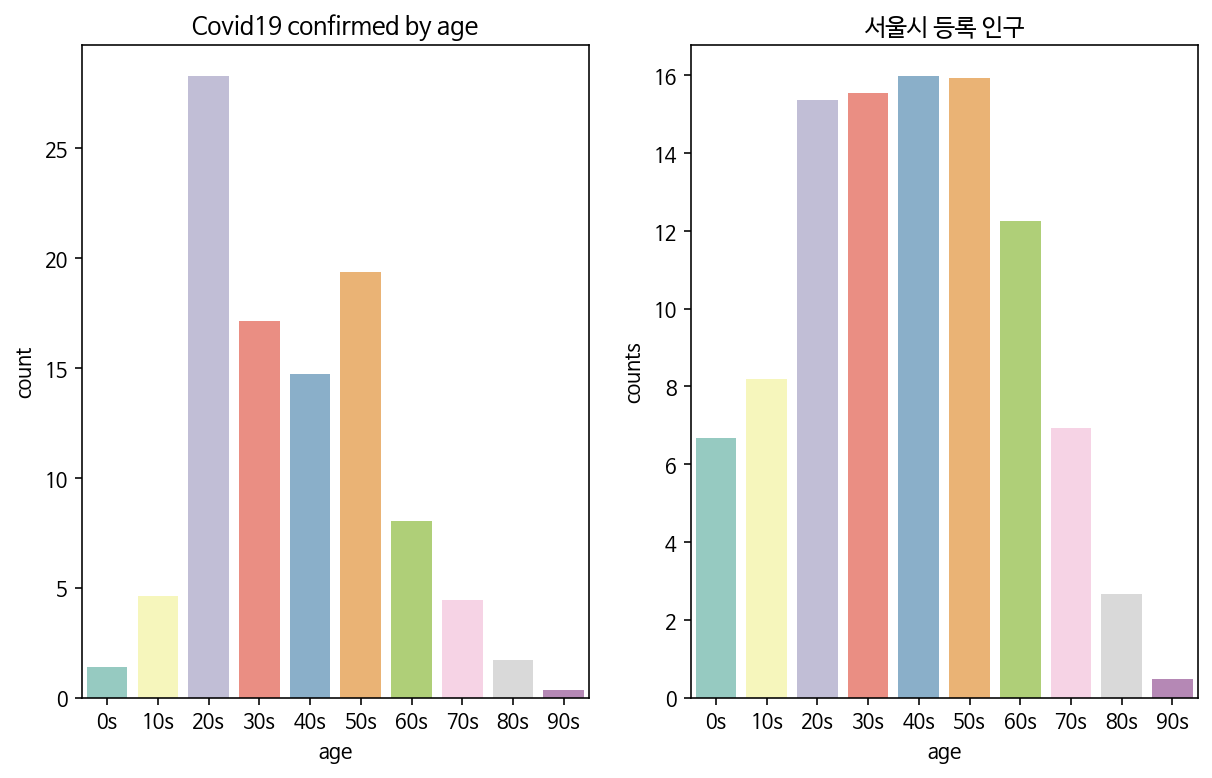

In [35]:
figure, ((ax1,ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(10,6)
sns.set_palette("Set3")

sns.barplot(data=covid_seoul_age, x="age", y="count", ax=ax1)
sns.barplot(data=seoul_age_total, x="age", y="counts", ax=ax2)

ax1.set(title="Covid19 confirmed by age")
ax2.set(title="서울시 등록 인구")

plt.show()

서울시 등록 인구 통계와 비교했을 때 20대가 압도적으로 많은 확진자를 보였습니다


---



### 1-3. 코로나 19 카테고리 분석

Covid19 집단 감염 케이스를 자세히 보면, 비슷한 장소에서 지속해서 발생하는 것을 확인할 수 있습니다. 이에 저희는 집단감염이 일어난 장소를 '카테고리'(소분류 / 중분류) 별로 분류해보았습니다. 이 때 카테고리는 소상공인시장진흥공단의 분류법에 따라 분류했습니다. 

콜센터는 제대로 분류되어있지 않아서, 임의로 K03C01 -> 보험회사 - 손해보험으로 분류했습니다.

정신병원의 경우 따로 소분류가 없어서 임의로 국립정신병원으로 분류했습니다.
자세한 분류는 https://radlohead.github.io/assets/index3.html 참조

##### 데이터 전처리

In [36]:
covid_group = covid_case[covid_case['group'] == True].copy()
covid_group.drop([' case_id','province','city','group','latitude','longitude'],axis=1,inplace=True)
covid_group= pd.DataFrame((covid_group['confirmed'].groupby(covid_group['infection_case'])).sum()) #코로나 확진자 수를 케이스별로 통합
covid_group.reset_index(inplace=True)
#감염 케이스를 리스트로 저장
infection_case = list(covid_group['infection_case'].unique())
#label하기 위한 dataFrame 생성
label = pd.DataFrame({'infection_case':infection_case, 
                                       'cat_code':['M01A01','R04A01','S07B05','S01B01','N02A01','S01B01','F04A01','L02A01','S01B01','L02A01','S05B06','M01A01','L02A01','M01A01','L02A01','S01B01','R20B01','S01B01','M01A01','L02A01','M01A01',np.nan, np.nan,'S06B03','M01A01',np.nan,'K03C01','M01A02','S05B06','S05B06','S07B05','M01A03','S01B01','S07B05','N02A02','R04A01','R20B01','C12B00','K03A00','V16C01','V09A14','M01A01','F04A01','M01A01','S06B12','V02A34','M01A01','K03A00','L02A01','M01A01','L02A01','M01A01','L02A01','M01A01','K03C01','S01B01','S01B18',np.nan,'L02A02',np.nan,'R14B04','V18B04','M01A00','Q12A01','M01A01','R08A03','S01B01','F04A01','M01A01','L02A03','L02A02','N01A05',np.nan,'R09A11','R01A01',np.nan,'P02A13','P02A13'],
                                       'cat_name':['기독교','학원-외국어/어학','요양원','종합병원','노래방','종합병원','택배업','임대-사무실/오피스텔/공장','종합병원','임대-사무실/오피스텔/공장','노인수용복지시설','기독교','임대-사무실/오피스텔/공장','기독교','임대-사무실/오피스텔/공장','종합병원','문화센터','종합병원','기독교','임대-사무실/오피스텔/공장','기독교',np.nan,np.nan,'노인정','기독교',np.nan,'보험회사-손해보험','불교','노인수용복지시설','노인수용복지시설','요양원','천주교','종합병원','요양원','나이트클럽','학원-외국어/어학','문화센터','셔츠/내의도매-종합','보험회사-생명보험','종교단체','산림청','기독교','택배업','기독교','장애인이용복지시설','해양수산부','기독교','보험회사-생명보험','임대-사무실/오피스텔/공장','기독교','임대-사무실/오피스텔/공장','기독교','임대-사무실/오피스텔/공장','기독교','보험회사-손해보험','종합병원','국립정신병원',np.nan,'임대-주택/아파트/연립',np.nan,'화학연구소','시도군구청','종교.임시','커피전문점/카페/다방','기독교','유치원','종합병원','택배업','기독교','임대-쇼핑센타/상점','임대-주택/아파트/연립','탁구장',np.nan,'학원-기타','학원-입시',np.nan,'헬스클럽','헬스클럽']})

In [37]:
covid_group_labeled = covid_group.merge(label,on='infection_case',how='outer')
covid_group_labeled['midcat_code']=covid_group_labeled.cat_code.str.slice(start=0,stop=3)
midcat_code = covid_group_labeled['midcat_code'].unique()
midcat = pd.DataFrame({'midcat_code':midcat_code,'midcat_name':['종교','학원','의료관련서비스업','병원','무도/유흥/가무','운송/배달/택배','부동산임대','수용복지시설','기타교육기관',np.nan,'비수용복지시설','보험','의류도매','단체','국가기관','국가기관','연구소','국가기관','커피점/카페','유아교육','PC/오락/당구/볼링등','학원','학원','실내운동시설']})
covid_group_labeled = covid_group_labeled.merge(midcat, on='midcat_code',how='outer')

####시각화 
코로나 집단 감염케이스는 총 78건이 있었는데, 카테고리는 총 32개로 설명할 수 있었습니다. 

또, 78건 케이스 중 50%에 해당하는 39건을 상위 6개 카테고리만으로 설명할 수 있었습니다.

In [38]:
covid_cat_frequency = pd.DataFrame(covid_group_labeled['cat_name'].value_counts()).reset_index()
covid_cat_frequency.columns=['category','frequency(번)']

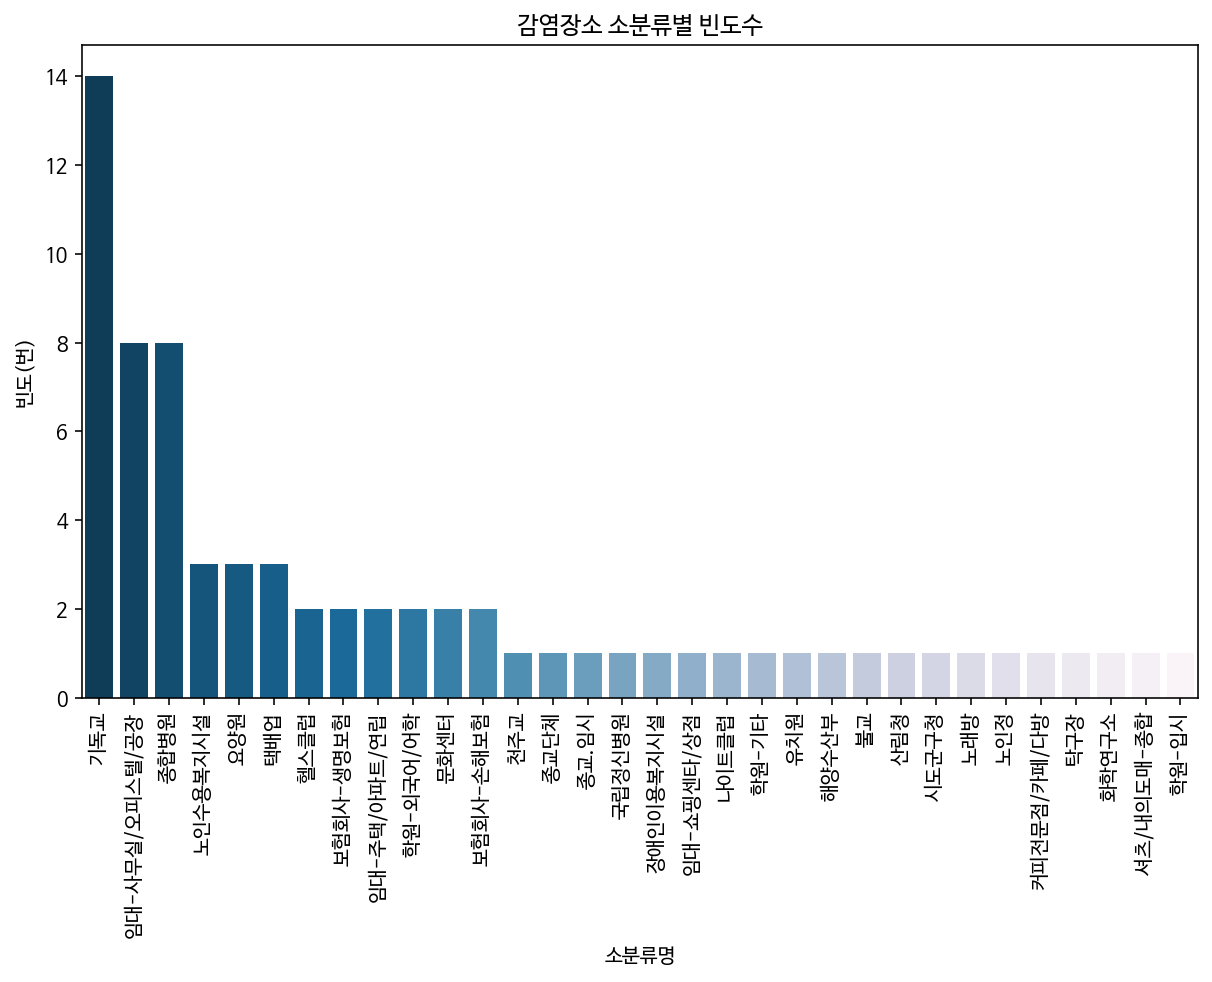

In [39]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(10,6)
sequential_colors = sns.color_palette("PuBu_r", 32)
sns.set_palette(sequential_colors)
sns.barplot(data=covid_cat_frequency, x="category", y="frequency(번)", ax=ax)
ax.set(title="감염장소 소분류별 빈도수",xlabel="소분류명", ylabel='빈도(번)')
plt.xticks(rotation=90)
plt.savefig('groupcasebycat.png',dpi=250, transparent=True, bbox_inches= "tight")
plt.show()

기독교에서 가장 빈번하게 집단감염이 발생했고, 다음 사무실/오피스텔 (다단계 등), 종합병원에서 많은 빈도로 집단감염이 발생했습니다. 

In [40]:
covid_midcat_frequency = pd.DataFrame(covid_group_labeled['midcat_name'].value_counts()).reset_index()
covid_midcat_frequency.columns=['midcat_name','frequency(번)']

중분류로 조금 더 크게 보면, 전체 74개 집단감염은 불과 19개 산업 카테고리에서 발생한 것을 확인할 수 있습니다.

즉, 코로나 집단감염이 발생한 장소와 '같은 행위'를 하는 장소에서 반복해서 집단감염이 발생한다는 것을 알 수 있습니다.

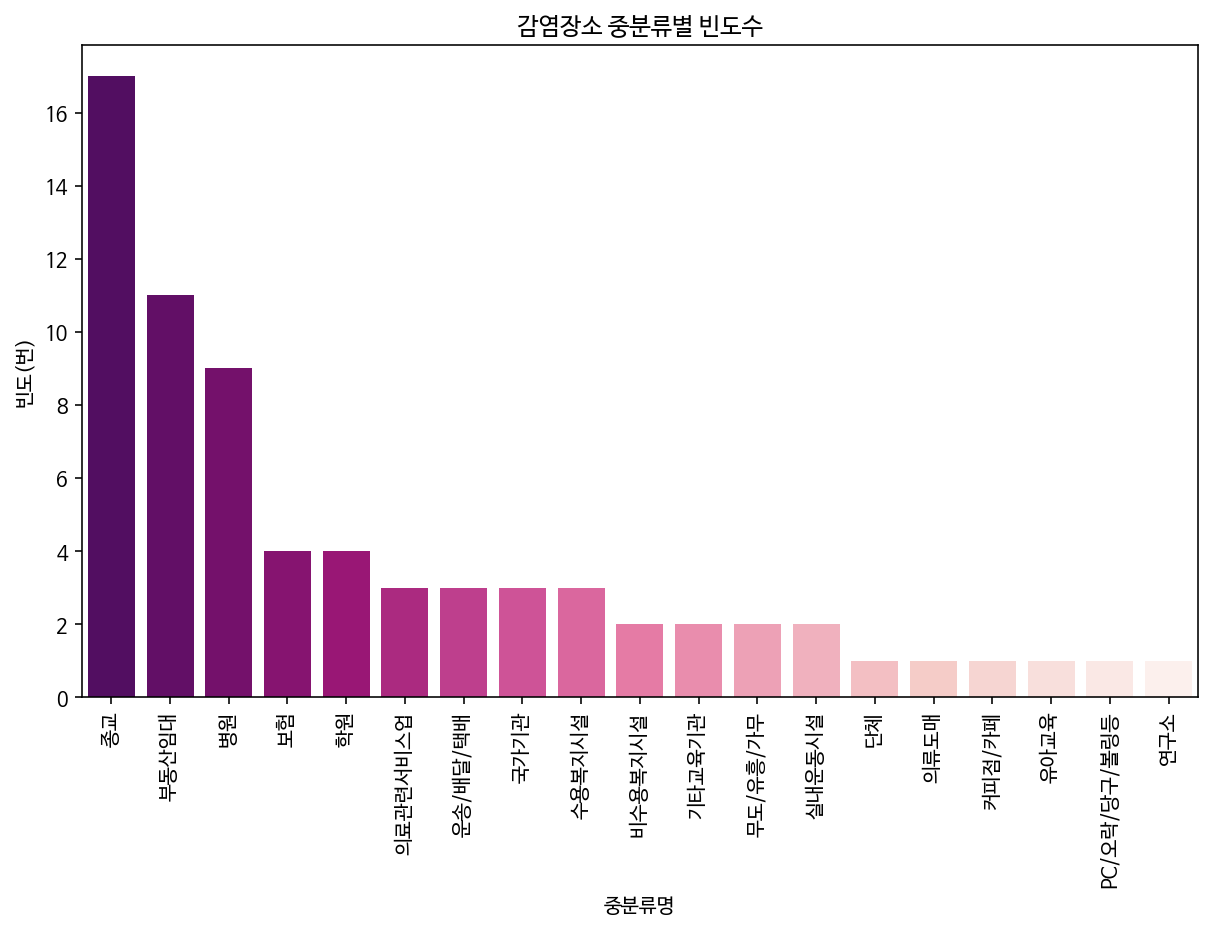

In [41]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(10,6)
sequential_colors = sns.color_palette("RdPu_r", 19)
sns.set_palette(sequential_colors)
sns.barplot(data=covid_midcat_frequency, x="midcat_name", y="frequency(번)", ax=ax)
ax.set(title="감염장소 중분류별 빈도수",xlabel="중분류명", ylabel='빈도(번)')
plt.xticks(rotation=90)
plt.savefig('groupcasebymidcat.png',dpi=250, transparent=True, bbox_inches= "tight")
plt.show()

종교와 부동산임대(부동산임대는 사무실, 오피스텔, 아파트 등을 전부 합친 중분류입니다) 병원에서 많은 빈도로 집단감염이 발생하고 있었습니다.

In [42]:
covid_count_group = pd.DataFrame(covid_group_labeled['confirmed'].groupby(covid_group_labeled['cat_name']).sum()).reset_index()
covid_count_group = covid_count_group.sort_values(by=['confirmed'],axis=0, ascending=False)

In [43]:
covid_count_group_mid = pd.DataFrame(covid_group_labeled['confirmed'].groupby(covid_group_labeled['midcat_name']).sum()).reset_index()
covid_count_group_mid = covid_count_group_mid.sort_values(by=['confirmed'],axis=0, ascending=False)

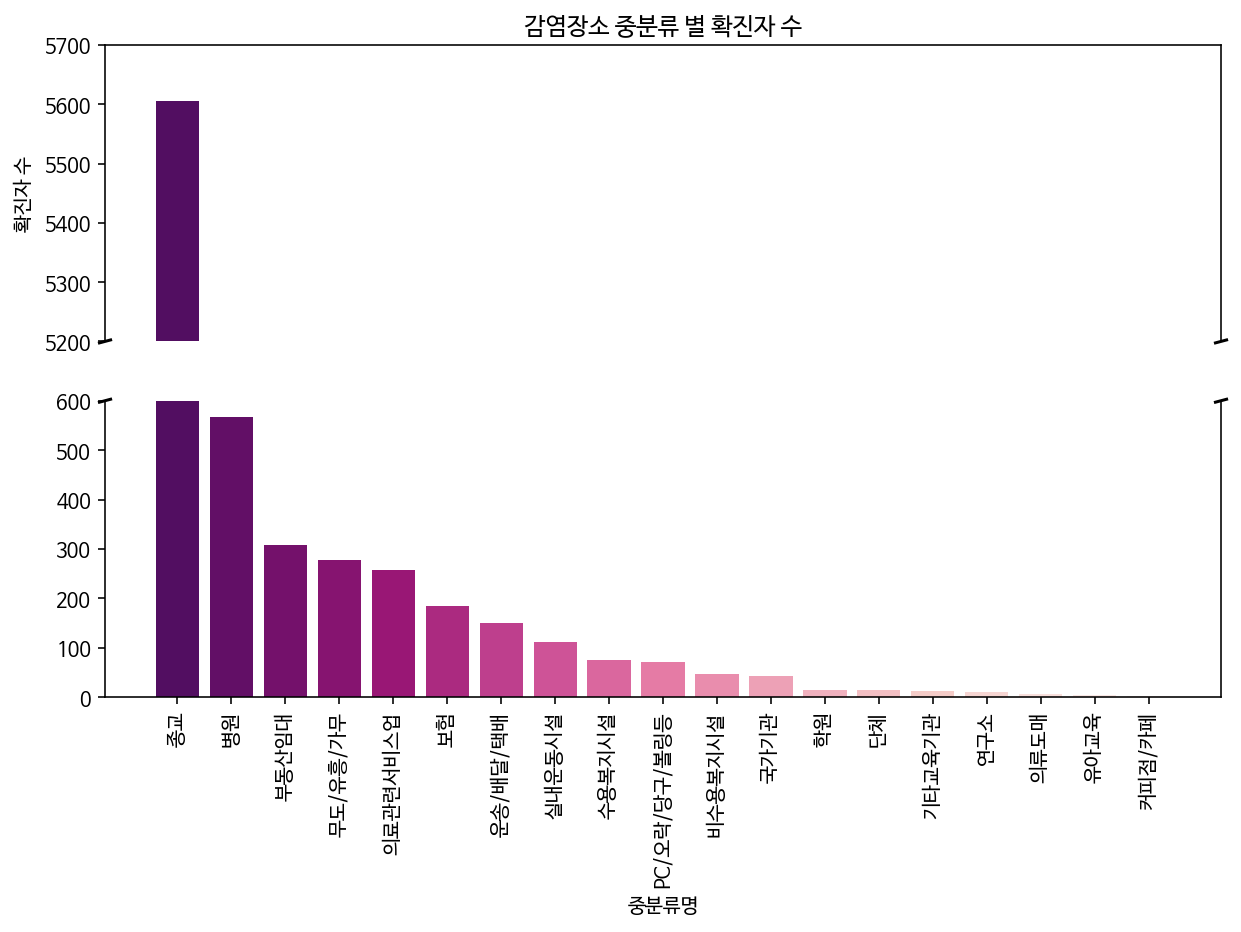

In [44]:
figure, ((ax,ax2)) = plt.subplots(nrows=2, ncols=1,sharex=True)
figure.set_size_inches(10,6)
sequential_colors = sns.color_palette("RdPu_r", 19)
sns.set_palette(sequential_colors)

sns.barplot(data=covid_count_group_mid, x="midcat_name", y="confirmed", ax=ax)
sns.barplot(data=covid_count_group_mid, x="midcat_name", y="confirmed", ax=ax2)

ax.set_ylim(5200,5700)
ax2.set_ylim(0, 600)

ax.xaxis.set_visible(False)
plt.ylabel('')
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False) 
ax2.xaxis.tick_bottom()
d = .005  # how big to make the diagonal lines in axes coordinates

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.set(title ='감염장소 중분류 별 확진자 수',ylabel='확진자 수')
ax2.set(xlabel = '중분류명')
plt.xticks(rotation=90)
plt.savefig('groupopbymidcat.png',dpi=250, transparent=True, bbox_inches= "tight")

plt.show()

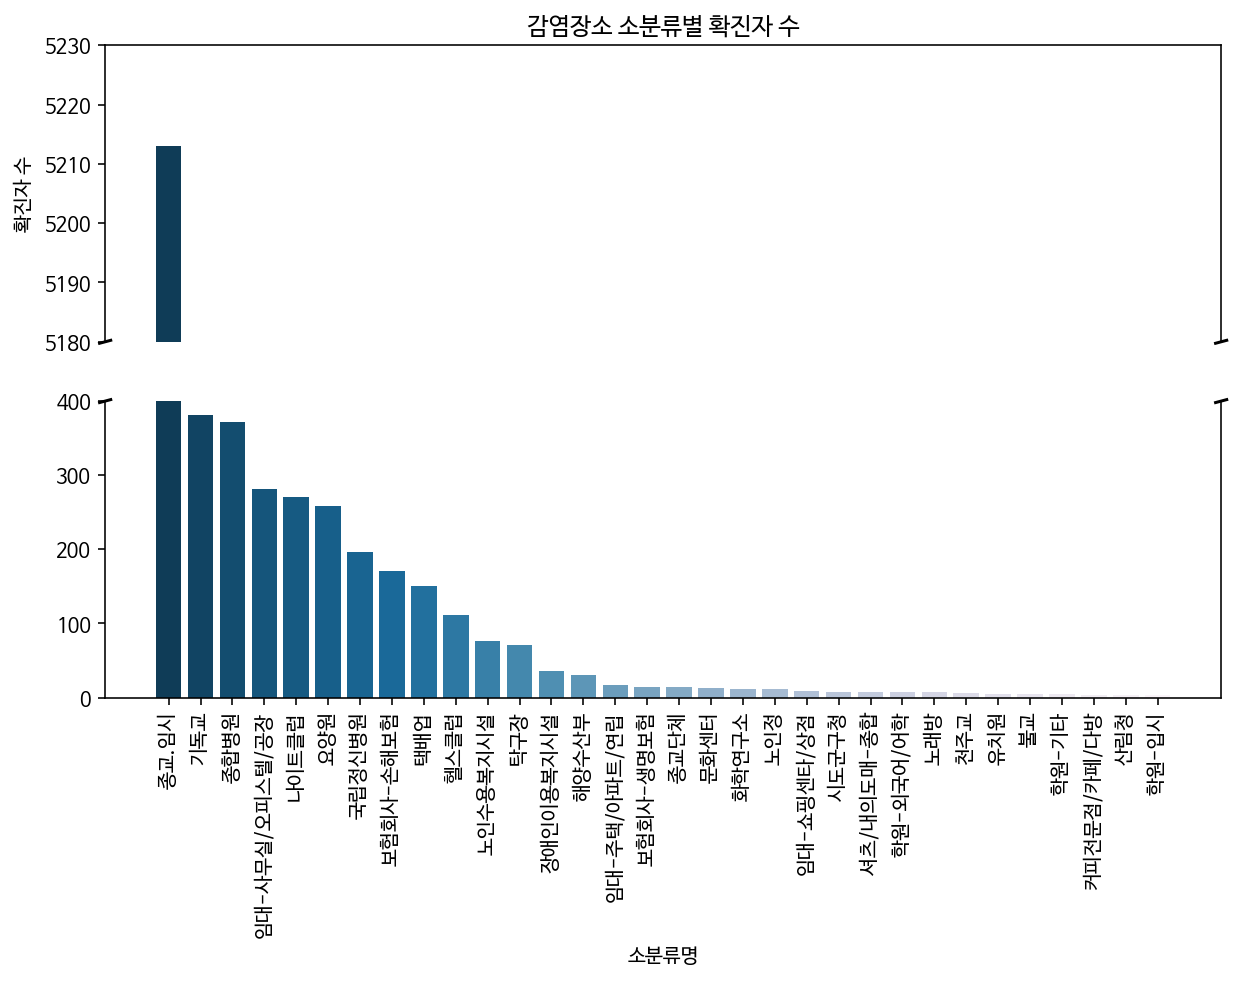

In [45]:
figure, ((ax,ax2)) = plt.subplots(nrows=2, ncols=1,sharex=True)
figure.set_size_inches(10,6)

sequential_colors = sns.color_palette("PuBu_r", 32)
sns.set_palette(sequential_colors)

sns.barplot(data=covid_count_group, x="cat_name", y="confirmed", ax=ax)
sns.barplot(data=covid_count_group, x="cat_name", y="confirmed", ax=ax2)

ax.set_ylim(5180,5230)
ax2.set_ylim(0, 400)

ax.xaxis.set_visible(False)
plt.ylabel('')
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False) 
ax2.xaxis.tick_bottom()
d = .005  # how big to make the diagonal lines in axes coordinates

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.set(title ='감염장소 소분류별 확진자 수',ylabel='확진자 수')
ax2.set(xlabel = '소분류명')
plt.xticks(rotation=90)
plt.savefig('groupopbycat.png',dpi=250, transparent=True, bbox_inches= "tight")
plt.show()

In [46]:
covid_group_labeled.head()

,infection_case,confirmed,cat_code,cat_name,midcat_code,midcat_name
0,Anyang Gunpo Pastors Group,23,M01A01,기독교,M01,종교
1,Dongan Church,17,M01A01,기독교,M01,종교
2,Dreaming Church,4,M01A01,기독교,M01,종교
3,Gangnam Dongin Church,1,M01A01,기독교,M01,종교
4,Geochang Church,10,M01A01,기독교,M01,종교


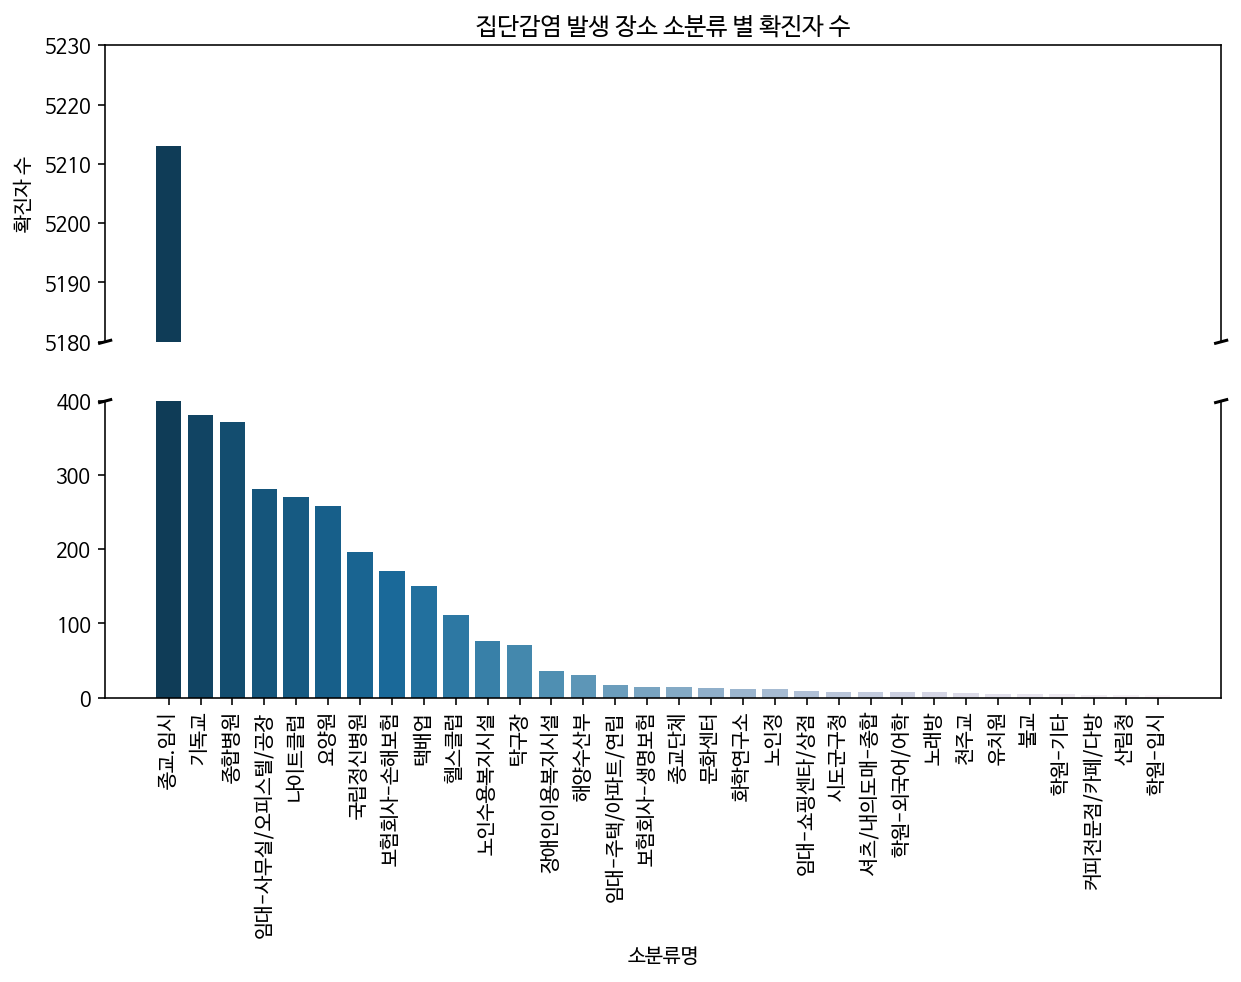

In [47]:
figure, ((ax,ax2)) = plt.subplots(nrows=2, ncols=1,sharex=True)
figure.set_size_inches(10,6)

sns.barplot(data=covid_count_group, x="cat_name", y="confirmed", ax=ax)
sns.barplot(data=covid_count_group, x="cat_name", y="confirmed", ax=ax2)

ax.set_ylim(5180,5230)
ax2.set_ylim(0, 400)

ax.xaxis.set_visible(False)
plt.ylabel('')
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False) 
ax2.xaxis.tick_bottom()
d = .005  # how big to make the diagonal lines in axes coordinates

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.set(title ='집단감염 발생 장소 소분류 별 확진자 수',ylabel='확진자 수')
ax2.set(xlabel = '소분류명')
plt.xticks(rotation=90)
plt.show()

확진자 수는 종교,임시 카테고리(신천지 등)에서 가장 많았고, 다음으로 기독교, 종합병원, 사무실/오피스텔/공장 (다단계 등), 나이트클럽, 요양병원, 정신병원 순이였습니다. 

## 2. 안전도 산출
안전도는 다음과 같은 식으로 산출됩니다.


base score : 각 집단감염이 발생한 장소의 감염자수 / 총 집단감염 감염자 수

소분류 점수 (bot_cat_score) : 소분류별로 base score을 전부 다 합산

중분류 점수 (mid_cat_score): 중분류에 해당하는 소분류들의 점수를 다 더한 뒤 * 0.1

ex) '종교' 중분류 점수 = (기독교 점수 + 불교 점수 + 천주교 점수 + ... ) *0.1

유동인구 점수 (fp_score): sum(연령대별 유동인구 수 x 연령대별 확진자 비율) x 0.01

**최종 점수** (final score): 소분류 점수 + 중분류 점수 + 유동인구 점수

**각 건물의 안전도** 

각 건물별로 최종 점수를 누적함.

ex) OO동 ACE빌딩 : 1층 스타벅스 점수 + 2층 노래방 점수 + 3층 보드게임방 점수 + ...

즉, 안전도가 0에 가까울 수록 안전함. 안전도가 클 수록 위험합니다.


### 2.1 데이터 전처리

소상공인시장진흥공단에서 서울시의 거의 대부분의 업체들을 상세하게 기록해 두었지만, 

종교, 병원, 요양원 등 특정 다중이용시설군의 정보가 누락되어있어 종교와 병원 등의 정보가 공공데이터 포털에 잘 올라와 있는 성동구를 대상으로 안전도를 산출하고 시각화하게 되었습니다. 

In [50]:
#소상공인시장진흥공단_상가(상권)정보_서울 https://www.data.go.kr/data/15059995/fileData.do
Seoul = pd.read_csv('/content/drive/My Drive/hakerton/Shopping/Shopping_Seoul_202006.csv', sep='|')
Seoul = pd.DataFrame(Seoul)
Seoul = Seoul.drop(Seoul.columns[[0,3,4,9,10,11,12,13,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]],axis=1)

In [ ]:
#소상공인 시장 진흥공단 상가정보(서울)에 종교와 병원 등의 정보가 누락되어 있어 누락된 정보를 추가해줍니다. 
#https://data.seoul.go.kr/dataList/OA-16479/S/1/datasetView.do 서울특별시 병원 인허가 정보 * 좌표안내 : 중부원점TM(EPSG:5174) 
seoul_hospitals = pd.DataFrame(pd.read_csv('/content/drive/My Drive/hakerton/Seoul_hos.csv',sep=',',encoding='CP949'))
seoul_hospitals = seoul_hospitals.drop(seoul_hospitals.columns[[0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,17,19,20,21,26,27,28,29,30,32,33,34,35,36,37,38,39,40]],axis=1) #필요없는 칼럼 제거
mask = seoul_hospitals['영업상태명'].isin(['폐업']) 
seoul_hospitals = seoul_hospitals[~mask]
seoul_hospitals = seoul_hospitals.drop(seoul_hospitals.columns[[0,6,7]],axis=1)
seoul_hospitals['시군구명'] = seoul_hospitals.도로명주소.str.split(' ').str[1]  #도로명주소에서 구 정보 추출
#업종 소분류코드 레이블
seoul_hospitals['상권업종소분류코드'] = 'S01B02'
seoul_hospitals.loc[seoul_hospitals['업태구분명']=='종합병원', '상권업종소분류코드'] = 'S01B01'
seoul_hospitals.loc[seoul_hospitals['업태구분명']=='치과병원', '상권업종소분류코드'] = 'S01B03'
seoul_hospitals.loc[seoul_hospitals['업태구분명']=='요양병원(일반요양병원)', '상권업종소분류코드'] = 'S07B05'
seoul_hospitals.loc[seoul_hospitals['업태구분명']=='한방병원', '상권업종소분류코드'] = 'S01B05'
seoul_hospitals.loc[seoul_hospitals['업태구분명']=='요양병원(노인병원)', '상권업종소분류코드'] = 'S01B17'
seoul_hospitals.loc[seoul_hospitals['업태구분명']=='요양병원(장애인의료재활시설)', '상권업종소분류코드'] = 'S01B03'
seoul_hospitals.loc[seoul_hospitals['업태구분명']=='요양병원(정신병원)', '상권업종소분류코드'] = 'S01B19'
#좌표변환 // 중부원점TM(EPSG:5174) -> WGS84 경위도 (EPSG:4326)
transformer = Transformer.from_crs('epsg:5174','epsg:4326')
def transform_TM_to_w84(df):
    return pd.Series(transformer.transform(df['좌표정보(Y)'],df['좌표정보(X)']), index=['좌표정보(X)','좌표정보(Y)'])
seoul_hospitals[['위도', '경도']] = seoul_hospitals.apply(transform_TM_to_w84, axis=1)
seoul_hospitals = seoul_hospitals[seoul_hospitals['도로명주소'].notnull()] #도로명 주소가 누락된 장소는 좌표를 구할 수 없음

In [ ]:
#좌표가 누락된 정보들을 도로명 주소와 국토교통부 V world geocoder API를 이용해 구해줍니다.
#http://www.vworld.kr/dev/v4dv_geocoderguide2_s001.do
address = ['서울특별시 강서구 마곡중앙4로 22 파인스퀘어 34층 (마곡동)',
 '서울특별시 중구 마른내로 9 (저동2가)',
 '서울특별시 성북구 안암로 99 (안암동5가)',
 '서울특별시 성북구 종암로 72 (종암동)',
 '서울특별시 성북구 동소문로 306 (하월곡동)',
 '서울특별시 도봉구 삼양로 606 (쌍문동)',
 '서울특별시 도봉구 도당로 51 (방학동)',
 '서울특별시 강서구 공항대로 237 456층 (마곡동)',
 '서울특별시 강서구 공항대로 260 이화여자대학교 제2부속병원 (마곡동)',
 '서울특별시 구로구 중앙로1길 18-18 (고척동 신원프라자)',
 '서울특별시 구로구 중앙로 91 (고척동)',
 '서울특별시 금천구 시흥대로73길 67 46층 (시흥동)',
 '서울특별시 송파구 법원로11길 32 지하2~1층 지상5~11층13층 (문정동)',
 '서울특별시 강동구 천호대로 1043 (천호동)',
 '서울특별시 금천구 시흥대로73길 67 엠타워 78914지하2층 (시흥동)',
 '서울특별시 강서구 공항대로 228 45층 (마곡동)']

for address in tqdm(address):
    try:    
        print(address)
        key = 'F37BABC4-8909-303E-9E81-FB47A6FBC61A'
        url = 'http://api.vworld.kr/req/address?'
        params = {'service': 'address', 'version':2.0, 'request':'GetCoord','key':key,'format':'json','type':'ROAD','address':address,'crs':'EPSG:4326'}
        r = requests.get(url, params=params)
        print((r.json())['response']['result']['point']['x'])
        print((r.json())['response']['result']['point']['y'])
        time.sleep(2)
    except:
        pass

In [ ]:
#좌표가 누락된 정보들을 도로명 주소와 국토교통부 V world geocoder API를 이용해 구해줍니다.
#http://www.vworld.kr/dev/v4dv_geocoderguide2_s001.do
address = ['서울특별시 강서구 마곡중앙4로 22 파인스퀘어 34층 (마곡동)',
 '서울특별시 중구 마른내로 9 (저동2가)',
 '서울특별시 성북구 안암로 99 (안암동5가)',
 '서울특별시 성북구 종암로 72 (종암동)',
 '서울특별시 성북구 동소문로 306 (하월곡동)',
 '서울특별시 도봉구 삼양로 606 (쌍문동)',
 '서울특별시 도봉구 도당로 51 (방학동)',
 '서울특별시 강서구 공항대로 237 456층 (마곡동)',
 '서울특별시 강서구 공항대로 260 이화여자대학교 제2부속병원 (마곡동)',
 '서울특별시 구로구 중앙로1길 18-18 (고척동 신원프라자)',
 '서울특별시 구로구 중앙로 91 (고척동)',
 '서울특별시 금천구 시흥대로73길 67 46층 (시흥동)',
 '서울특별시 송파구 법원로11길 32 지하2~1층 지상5~11층13층 (문정동)',
 '서울특별시 강동구 천호대로 1043 (천호동)',
 '서울특별시 금천구 시흥대로73길 67 엠타워 78914지하2층 (시흥동)',
 '서울특별시 강서구 공항대로 228 45층 (마곡동)']

for address in tqdm(address):
    try:    
        print(address)
        key = '2FAF48CA-DB69-3E7D-A50B-5B9A4A045A1E'
        url = 'http://api.vworld.kr/req/address?'
        params = {'service': 'address', 'version':2.0, 'request':'GetCoord','key':key,'format':'json','type':'ROAD','address':address,'crs':'EPSG:4326'}
        r = requests.get(url, params=params)
        print((r.json())['response']['result']['point']['x'])
        print((r.json())['response']['result']['point']['y'])
        time.sleep(2)
    except:
        pass

  0%|          | 0/16 [00:00<?, ?it/s]

서울특별시 강서구 마곡중앙4로 22 파인스퀘어 34층 (마곡동)


  6%|▋         | 1/16 [00:19<04:56, 19.75s/it]

서울특별시 중구 마른내로 9 (저동2가)


 19%|█▉        | 3/16 [00:20<02:08,  9.90s/it]

서울특별시 성북구 안암로 99 (안암동5가)
서울특별시 성북구 종암로 72 (종암동)


 25%|██▌       | 4/16 [00:21<01:24,  7.05s/it]

서울특별시 성북구 동소문로 306 (하월곡동)


 38%|███▊      | 6/16 [00:21<00:35,  3.55s/it]

서울특별시 도봉구 삼양로 606 (쌍문동)
서울특별시 도봉구 도당로 51 (방학동)


 50%|█████     | 8/16 [00:21<00:14,  1.85s/it]

서울특별시 강서구 공항대로 237 456층 (마곡동)
서울특별시 강서구 공항대로 260 이화여자대학교 제2부속병원 (마곡동)


 56%|█████▋    | 9/16 [00:22<00:09,  1.34s/it]

서울특별시 구로구 중앙로1길 18-18 (고척동 신원프라자)


 69%|██████▉   | 11/16 [00:22<00:03,  1.32it/s]

서울특별시 구로구 중앙로 91 (고척동)
서울특별시 금천구 시흥대로73길 67 46층 (시흥동)


 75%|███████▌  | 12/16 [00:22<00:02,  1.62it/s]

서울특별시 송파구 법원로11길 32 지하2~1층 지상5~11층13층 (문정동)


 88%|████████▊ | 14/16 [00:24<00:01,  1.31it/s]

서울특별시 강동구 천호대로 1043 (천호동)
서울특별시 금천구 시흥대로73길 67 엠타워 78914지하2층 (시흥동)


 94%|█████████▍| 15/16 [00:25<00:00,  1.61it/s]

서울특별시 강서구 공항대로 228 45층 (마곡동)


100%|██████████| 16/16 [00:27<00:00,  1.70s/it]


In [ ]:
seoul_hospitals.drop(['업태구분명','좌표정보(X)','좌표정보(Y)'],axis=1,inplace=True)
seoul_hospitals.columns=['도로명주소','상호명','시군구명','상권업종소분류코드','위도','경도']
seoul_hospitals['상권업종중분류코드']=seoul_hospitals.상권업종소분류코드.str.slice(start=0,stop=3)
seoul_hospitals['행정동명'] = seoul_hospitals.도로명주소.str.split('(').str[-1]
seoul_hospitals['행정동명'] = seoul_hospitals.행정동명.str.split(')').str[0]
seoul_hospitals['위도'].isnull().sum()  #결측치 
#병합
Seouls = pd.concat([Seoul,seoul_hospitals],ignore_index=True)

종교정보 역시 누락되어있었는데, 서울특별시의 종교시설 데이터는 몇몇 자치구에서밖에 제공되지 않아, 성동구의 종교시설현황을 가지고 분석하게 되었습니다.

In [ ]:
#서울특별시_성동구_종교시설현황 https://www.data.go.kr/data/15032591/fileData.do
seoul_religion = pd.DataFrame(pd.read_csv('/content/drive/My Drive/hakerton/sungdong_religion.csv',sep=',',encoding='CP949'))
seoul_religion['시군구명']='성동구'
#소분류 코드 레이블
seoul_religion['상권업종소분류코드'] = 'M01A01'
seoul_religion.loc[seoul_religion['구분']=='사찰', '상권업종소분류코드'] = 'M01A02'
seoul_religion.loc[seoul_religion['구분']=='성당', '상권업종소분류코드'] = 'M01A03'
seoul_religion.loc[seoul_religion['구분']=='기타', '상권업종소분류코드'] = 'M01A00'
#중분류 코드 레이블링
seoul_religion['상권업종중분류코드']=seoul_religion.상권업종소분류코드.str.slice(start=0,stop=3)

In [ ]:
for address in tqdm(list(seoul_religion['소재지'])):
    try:
        address = address
        key = 'F37BABC4-8909-303E-9E81-FB47A6FBC61A'
        url = 'http://api.vworld.kr/req/address?'
        params = {'service': 'address', 'version':2.0, 'request':'GetCoord','key':key,'format':'json','type':'ROAD','address':address,'crs':'EPSG:4326'}
        r = requests.get(url, params=params)
        print(r.status_code)
        seoul_religion.loc[seoul_religion['소재지']==address, '경도'] = (r.json())['response']['result']['point']['x']
        seoul_religion.loc[seoul_religion['소재지']==address, '위도'] = (r.json())['response']['result']['point']['y']
        time.sleep(3)
    except:
        pass

100%|██████████| 165/165 [01:05<00:00,  2.53it/s]


In [ ]:
key = 'F37BABC4-8909-303E-9E81-FB47A6FBC61A'
url = 'http://api.vworld.kr/req/address?'
params = {'service': 'address', 'version':2.0, 'request':'getcoord','key':key,'format':'json','type':'ROAD','address':'서울시 구로구 개봉로 20길 158','crs':'EPSG:4326'}
r = requests.get(url, params=params)

In [ ]:
#소재지 도로명 주소가 잘못되어 좌표가 찾아지지 않는 장소 필터링
seoul_religion.loc[seoul_religion['명칭']=='홍익교회', '소재지'] = '서울특별시 성동구 마장동 살곶이2길 28'
seoul_religion.loc[seoul_religion['명칭']=='마장제일교회', '소재지'] = '서울특별시 성동구 마장동 마장로35길 76'
seoul_religion.loc[seoul_religion['명칭']=='숭덕교회', '소재지'] = '서울특별시 성동구 금호동3가 무수막18길 38'
seoul_religion.loc[seoul_religion['명칭']=='보덕사', '소재지'] = np.nan
seoul_religion.loc[seoul_religion['명칭']=='대한하나님의 성회', '소재지'] = '서울 성동구 왕십리로31나길 18'
seoul_religion = seoul_religion[seoul_religion['명칭'].notnull()]
nulldata = list(seoul_religion[seoul_religion['경도'].isnull()]['소재지'])

In [ ]:
#도로명 주소를 고친 누락데이터에 대해서 다시 좌표를 구해줍니다. durl
for address in tqdm(nulldata):
    try:
        address = address
        key = '2FAF48CA-DB69-3E7D-A50B-5B9A4A045A1E'
        url = 'https://api.vworld.kr/req/address?'
        params = {'service': 'address', 'version':2.0, 'request':'GetCoord','key':key,'format':'json','type':'ROAD','address':address,'crs':'EPSG:4326'}
        r = requests.get(url, params=params)
        seoul_religion.loc[seoul_religion['소재지']==address, '경도'] = (r.json())['response']['result']['point']['x']
        seoul_religion.loc[seoul_religion['소재지']==address, '위도'] = (r.json())['response']['result']['point']['y']
        time.sleep(2)
    except:
        pass

seoul_religion.drop(['구분','연락처'],axis=1,inplace=True)
seoul_religion.columns=['상호명','도로명주소','행정동명','시군구명','상권업종소분류코드','상권업종중분류코드','경도','위도']

In [ ]:
#종교 정보 통합
Seouls = pd.concat([Seouls,seoul_religion],ignore_index=True)

NameError: ignored

### 2.2 안전도 계산

In [ ]:
#성동구 정보만 추출
seongdong = Seouls[Seouls['시군구명']=='성동구'].copy()
seongdong.reset_index(drop=True,inplace=True)
seongdong.drop(['지점명','시군구명','행정동코드','법정동코드','법정동명'],axis=1,inplace=True)

In [ ]:
figure, ((ax,ax2)) = plt.subplots(nrows=1, ncols=2,sharey=True)
figure.set_size_inches(15,4)

sequential_colors = sns.color_palette("PuBu_r", 32)
sns.set_palette(sequential_colors)

sns.histplot(covid_group_labeled['confirmed'],bins=800, ax=ax)
sns.histplot(covid_group_labeled['confirmed'],bins=800, ax=ax2)

ax.set_xlim(0,140)
ax2.set_xlim(5100, 5300)

ax2.yaxis.set_visible(False)
plt.ylabel('')
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.set(title="집단 감염 감염자 수에 따른 빈도(logscale)",xlabel="감염자 수", ylabel="Frequency")
plt.yscale('log')
plt.savefig('frequnecylogscal.png',dpi=250, transparent=True, bbox_inches= "tight")
plt.show()

In [48]:
#base 점수를 구해줍니다.기존방식
covid_group_labeled['base_score'] = (covid_group_labeled['confirmed']/covid_group_labeled['confirmed'].sum(axis=0)) 
#소분류 점수를 구해줍니다.
bot_cat_score = covid_group_labeled['base_score'].groupby(covid_group_labeled['cat_code']).sum()
bot_cat_score = pd.DataFrame(bot_cat_score).reset_index()
bot_cat_score.columns=['cat_code','bot_cat_score']
#소분류 점수를 join해줍니다.
covid_group_botscore= covid_group_labeled.merge(bot_cat_score, on='cat_code', how='inner')
covid_group_botscore = covid_group_botscore.sort_values(by=['bot_cat_score'],ascending=False,axis=0)
covid_group_botscore.reset_index(drop=True,inplace=True)
formid = covid_group_botscore.drop(index=0,axis=0)
bot_cat_score.columns=['업종소분류코드','bot_cat_score']
#중분류 점수를 구해줍니다. 
mid_cat_score = pd.DataFrame(formid['bot_cat_score'].groupby(formid['midcat_code']).mean())
mid_cat_score=mid_cat_score.reset_index()
mid_cat_score.columns=['업종중분류코드','mid_cat_score']

In [49]:
#전체 카테고리
catcode = pd.DataFrame(pd.read_csv('/content/drive/My Drive/hakerton/cat_code.csv', encoding='euc-kr'))

#소분류점수, 중분류점수 merge
scores = catcode.merge(bot_cat_score, on='업종소분류코드', how='outer')
scores = scores.merge(mid_cat_score, on='업종중분류코드', how='outer')

#Nan값을 0으로 변경
scores.replace({'bot_cat_score': np.nan}, {'bot_cat_score': 0},inplace=True)
scores.replace({'mid_cat_score': np.nan}, {'mid_cat_score': 0},inplace=True)

#Final score는 bot_cat_score + mid_cat_score의 평균
scores['final_score'] = (scores['bot_cat_score'] + scores['mid_cat_score']) /2

scores = scores.sort_values(by=['final_score'],ascending=False,axis=0)

#bot
botscorenozero = scores[scores['bot_cat_score'] !=0]
botscorenozero = botscorenozero.sort_values(by=['bot_cat_score'],ascending=False,axis=0)
botscorenozero.reset_index(drop=True,inplace=True)
#mid
midscorenozero = scores[scores['mid_cat_score'] !=0]
midscorenozero = midscorenozero.sort_values(by=['mid_cat_score'],ascending=False,axis=0)
midscorenozero.reset_index(drop=True,inplace=True)
#final
scorenozero = scores[scores['final_score'] !=0]
scorenozero.reset_index(drop=True,inplace=True)

In [ ]:
#File 저장
scorenozero.to_csv('finalscore.csv',encoding='euc-kr')

In [50]:
scorenozero.head(50)

,업종대분류코드,업종대분류명,업종중분류코드,업종중분류명,업종소분류코드,업종소분류명,bot_cat_score,mid_cat_score,final_score
0,M,문화/예술/종교,M01,종교,M01A00,종교.임시,0.663992,0.042550,0.353271
1,S,의료,S01,병원,S01B01,종합병원,0.047382,0.044892,0.046137
2,M,문화/예술/종교,M01,종교,M01A01,기독교,0.048529,0.042550,0.045540
3,S,의료,S01,병원,S01B18,국립정신병원,0.024965,0.044892,0.034928
4,S,의료,S07,의료관련서비스업,S07B05,요양원,0.032862,0.032862,0.032862
5,L,부동산,L02,부동산임대,L02A01,임대-사무실/오피스텔/공장,0.035919,0.026621,0.031270
6,N,관광/여가/오락,N02,무도/유흥/가무,N02A02,나이트클럽,0.034518,0.017705,0.026111
7,S,의료,S01,병원,S01B14,이비인후과의원,0.000000,0.044892,0.022446
8,S,의료,S01,병원,S01B20,보건소,0.000000,0.044892,0.022446
9,S,의료,S01,병원,S01B06,한의원,0.000000,0.044892,0.022446


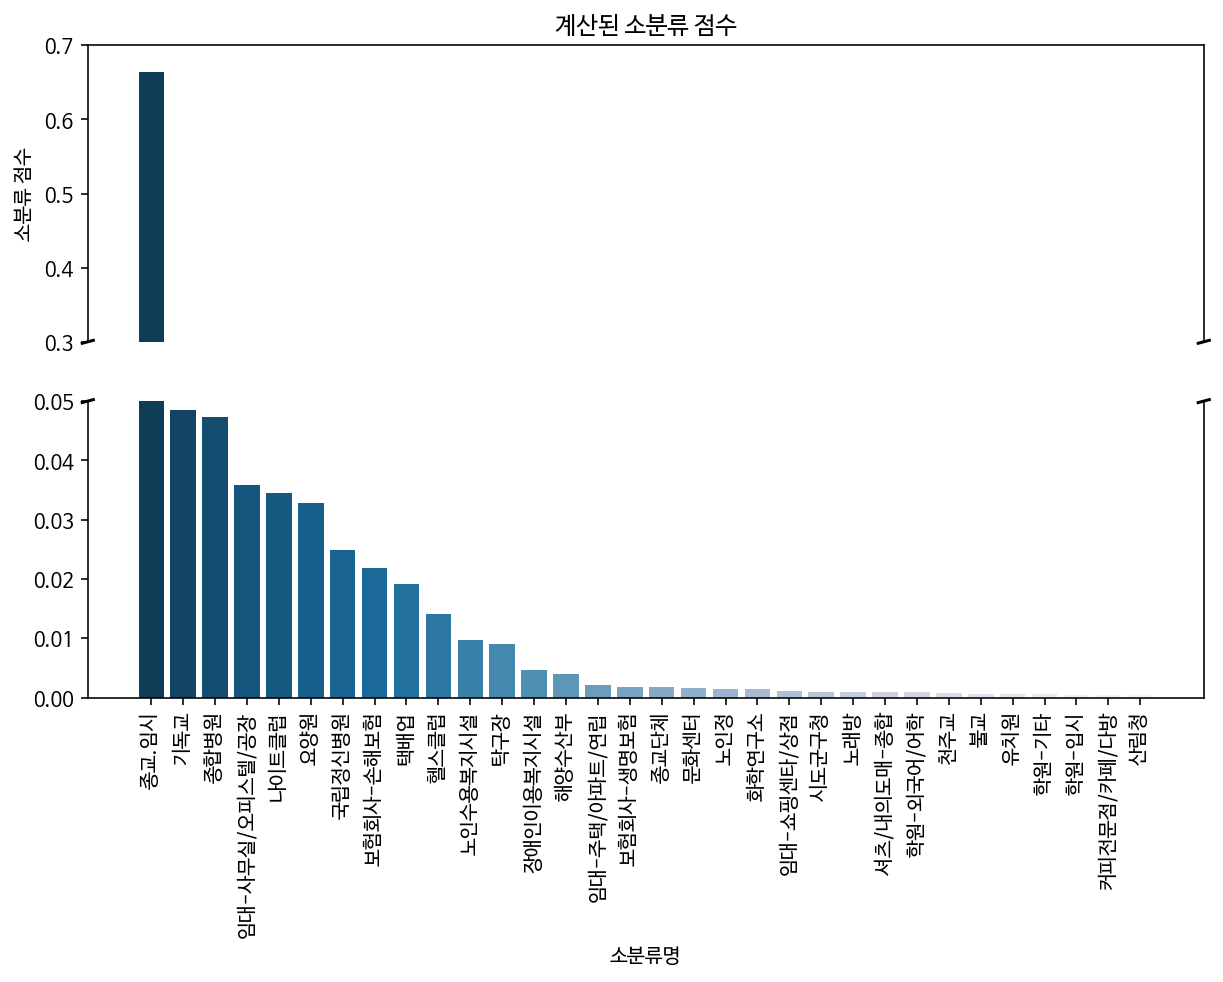

In [ ]:
figure, ((ax,ax2)) = plt.subplots(nrows=2, ncols=1,sharex=True)
figure.set_size_inches(10,6)
sequential_colors = sns.color_palette("PuBu_r", 32)
sns.set_palette(sequential_colors)
sns.barplot(data=botscorenozero, x="업종소분류명", y="bot_cat_score", ax=ax)
sns.barplot(data=botscorenozero, x="업종소분류명", y="bot_cat_score", ax=ax2)

ax.set_ylim(0.3,0.7)
ax2.set_ylim(0, 0.05)

ax.xaxis.set_visible(False)
plt.ylabel('')
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False) 
ax2.xaxis.tick_bottom()
d = .005  # how big to make the diagonal lines in axes coordinates

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


ax.set(title ='계산된 소분류 점수',ylabel='소분류 점수')
ax2.set(xlabel='소분류명')
plt.xticks(rotation=90)
plt.savefig('소분류.png',dpi=250, transparent=True, bbox_inches= "tight")

plt.show()

In [ ]:
sequential_colors2 = sns.color_palette("RdPu_r", 19)

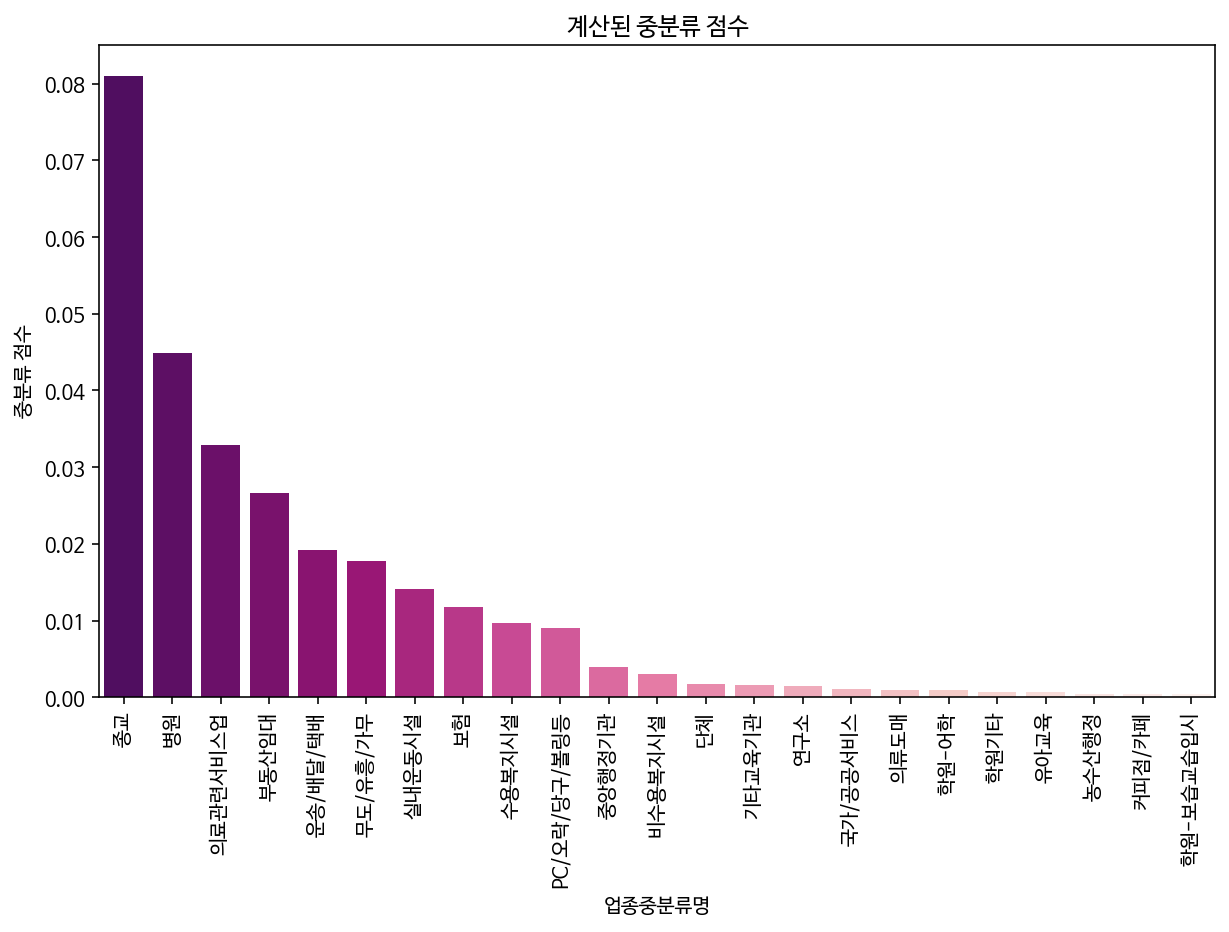

In [ ]:
figure, (ax) = plt.subplots(nrows=1, ncols=1,sharex=True)
figure.set_size_inches(10,6)
sequential_colors = sns.color_palette("RdPu_r", 23)
sns.set_palette(sequential_colors)

sns.barplot(data=midscorenozero, x="업종중분류명", y="mid_cat_score", ax=ax)

ax.set(title ='계산된 중분류 점수',ylabel='중분류 점수')
plt.xticks(rotation=90)
plt.savefig('중분류.png',dpi=250, transparent=True, bbox_inches= "tight")
plt.show()


In [ ]:
#법정동명으로 구해진 곳들을 전부 행정동명으로 구해줍니다.
seongdong_score['행정동명'].replace(
    to_replace=['도선동', '행당동', '하왕십리동', '성수동2가', '홍익동', '용답동 JS빌딩', '왕십리제2동', '행당제1동', '행당제2동', '금호2-3가동', 
                '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '왕십리성당', '마장동성당', '행당동성당', '금호동성당', '옥수동성당','성수동성당'],
    value=['왕십리도선동', '행당1동', '왕십리도선동', '성수2가3동', '왕십리도선동', '용답동', '왕십리2동', '행당1동', '행당2동', '금호2.3가동', 
           '성수1가1동', '성수1가2동', '성수2가1동', '성수2가3동', '왕십리도선동', '마장동', '행당2동', '금호2.3가동', '옥수동','성수1가1동'],
    inplace=True)

In [ ]:
#시각화및 유동인구점수를 위한 처리
seongdong_score['time'] = datetime.datetime(2020, 3, 3, hour=0, minute = 0)
seongdong_score_wtime = seongdong_score.loc[seongdong_score.index.repeat(24)].copy()
seongdong_score_wtime = seongdong_score_wtime.reset_index(drop=True)
seongdong_score_wtd = seongdong_score_wtime.to_dict()
#임의의 날짜 (3월 3일) 을 고름
start = datetime.datetime(2020, 3, 3, hour=0, minute = 0)
end = datetime.datetime(2020,3, 3, hour =23, minute = 0)
timeindex = pd.date_range(start, end, freq='H')
for i in range(0,len(seongdong_score_wtd['time'])):
    seongdong_score_wtd['time'][i] = timeindex[i%24]
seongdong_score_wtd = pd.DataFrame(seongdong_score_wtd)
seongdong_score_wtd=seongdong_score_wtd.fillna(0)
#유동인구 정보에서 2020년 3월 3일 성동구 정보만 가져옵니다.
yudnog_sd = yudong[(yudong['signgu_nm']=='성동구') &(yudong['base_ymd']==20200303)].copy()

In [ ]:
#시간 전처리
yudnog_sd['tmzon_se_code'].replace({0:'0000',1:'0100',2:'0200',3:'0300',4:'0400',5:'0500',6:'0600',7:'0700',8:'0800',9:'0900',10:'1000',11:'1100',12:'1200',13:'1300',14:'1400',15:'1500',16:'1600',17:'1700',18:'1800',19:'1900',20:'2000',21:'2100',22:'2200',23:'2300'},inplace=True)
yudnog_sd['tmzon_se_code'] = yudnog_sd['tmzon_se_code'].astype(str)
yudnog_sd['base_ymd'] = yudnog_sd['base_ymd'].astype(str)
yudnog_sd['time'] = yudnog_sd[['base_ymd','tmzon_se_code']].apply(lambda x:' '.join(x),axis=1)
#시간데이터로 변환
yudnog_sd['time'] = pd.to_datetime(yudnog_sd['time'])
yudnog_sd['agrde_se_code'].replace(
    to_replace=['age_00', 'age_10', 'age_15', 'age_20', 'age_25', 'age_30','age_35', 'age_40', 'age_45', 'age_50', 'age_55', 'age_60','age_65', 'age_70'],
    value=['0s', '10s', '10s', '20s', '20s', '30s','30s', '40s', '40s', '50s', '50s', '60s','60s', '70s'],
    inplace=True)

In [ ]:
#연령대별로 코로나 확진비율과 유동인구를 곱해서 유동인구 점수(fp_score)를 구해줍니다.
yudong_score = pd.DataFrame(yudnog_sd.groupby(['time','adstrd_nm','agrde_se_code'])['popltn_cascnt'].sum()).reset_index()
yudong_score.columns=['time','행정동명','age','popltn']
covid_seoul_age['ratio']  = covid_seoul_age['count'] / 100
yudong_score = yudong_score.merge(covid_seoul_age, how='inner', on='age')
yudong_score['fp_score'] = yudong_score['popltn'] * yudong_score['ratio'] * 0.01

In [ ]:
seongdong_score_wtd.reset_index(drop=True, inplace=True)
#유동인구 점수를 각 시간에 맞게, 연령대별 점수를 전부 더해 유동인구 점수를 구해줍니다.
for index in tqdm(list(seongdong_score_wtd.index)):
    adstrd = seongdong_score_wtd.loc[index,'행정동명']
    time = seongdong_score_wtd.loc[index,'time']
    fpscore = yudong_score[(yudong_score['time'] == time) & (yudong_score['행정동명']== adstrd)]['fp_score'].sum()
    seongdong_score_wtd.loc[index,'fp_score'] = fpscore

100%|██████████| 232488/232488 [12:35<00:00, 307.81it/s]


In [ ]:
#최종점수를 구해줍니다. 
seongdong_score_wtd['final_score'] = seongdong_score_wtd['bot_cat_score'] + seongdong_score_wtd['mid_cat_score'] + seongdong_score_wtd['fp_score'] 
seongdong_score_wtd.drop('도로명주소',axis=1,inplace=True)
seongdong_score_wtd = seongdong_score_wtd.reindex(columns=['상호명','상권업종중분류코드','상권업종소분류코드','상권업종중분류명','상권업종소분류명','행정동명','위도','경도','bot_cat_score','mid_cat_score','fp_score','final_score','time','fillColor'])

In [ ]:
#점수에 따른 색 지정
seongdong_score_wtd['fillColor'] = '#eb0e0e'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<140 , 'fillColor'] = '#ff2600'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<120 , 'fillColor'] = '#ff3000'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<100 , 'fillColor'] = '#ff3500'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<80 , 'fillColor'] = '#ff4000'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<60 , 'fillColor'] = '#ff5e00'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<50 , 'fillColor'] = '#ff833b'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<40 , 'fillColor'] = '#ffa069'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<35 , 'fillColor'] = '#ffaf38'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<30 , 'fillColor'] = '#ffd34d'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<25 , 'fillColor'] = '#ffe74d'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<20 , 'fillColor'] = '#ebff66'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<15 , 'fillColor'] = '#c9ff66'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<10 , 'fillColor'] = '#a8ff66'
seongdong_score_wtd.loc[seongdong_score_wtd['final_score']<5 , 'fillColor'] = '#80ff66'

In [ ]:
#시각화하기 위해 행당1동, 왕십리선도동, 왕십리2동 데이터를 뽑았습니다.
wnh = seongdong_score_wtd[(seongdong_score_wtd['행정동명']=='행당1동') | (seongdong_score_wtd['행정동명']=='왕십리도선동') | (seongdong_score_wtd['행정동명']=='왕십리2동')].copy()
wnh.reset_index(drop=True,inplace=True)

### 2.3 안전도 분석

유동인구는 평균적으로 11점정도를 기록하고 있었습니다.

In [51]:
scorenozero['final_score']

0.006337306849205077

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


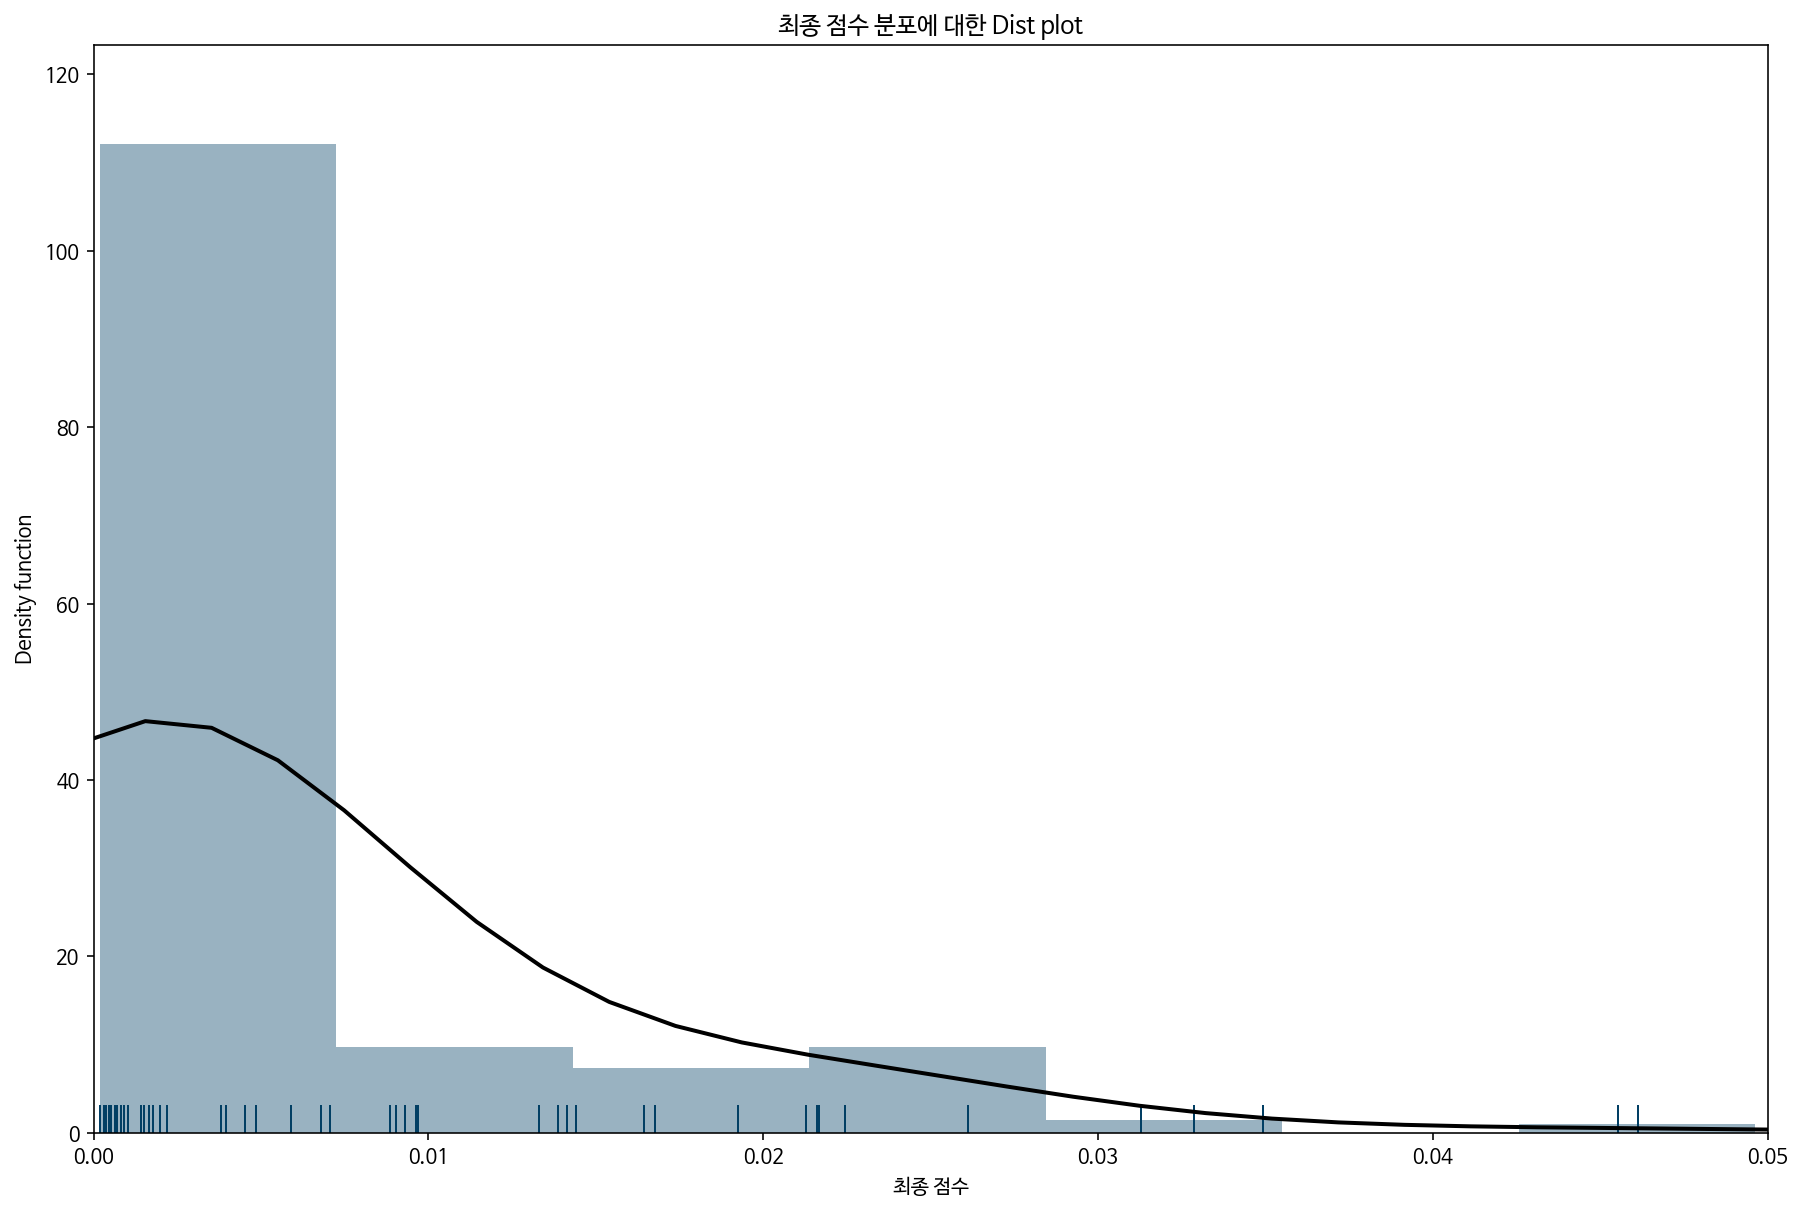

In [56]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(15,10)
sns.distplot(scorenozero['final_score'], kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},rug=True, ax=ax)
plt.xlim(0,0.05)
ax.set(title="최종 점수 분포에 대한 Dist plot",xlabel="최종 점수",ylabel="Density function")
plt.show()

위 그래프에서 KDE는 Kernel Density Estimation - 커널 밀도 추정을 의미합니다. 여기서 밀도는 확률밀도 (Probability density)입니다. KDE는 non-parametric density estimation 중 하나입니다. Kernel function을 데이터 마다 반복적으로 적용하고 전체 데이터개수로 나누어줌으로써 smooth한 확률밀도함수(PDF)를 얻는 방법입니다. 

최종점수는 평균적으로 14점정도를 기록하고 있었습니다.

In [ ]:
seongdong_score_wtd['final_score'].mean()

14.759714444785414

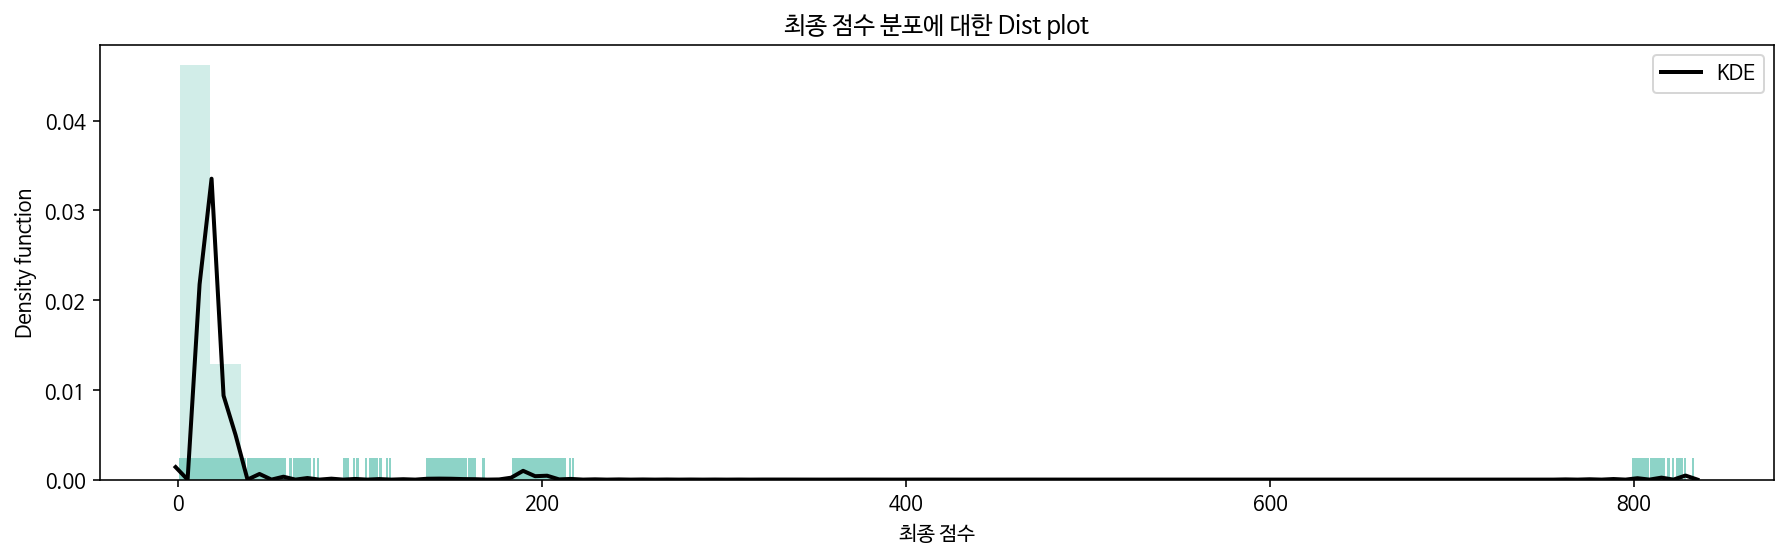

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(15,4)
sns.distplot(seongdong_score_wtd['final_score'], kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},rug=True, ax=ax)
sns.set_palette('RdBu')
ax.set(title="최종 점수 분포에 대한 Dist plot",xlabel="최종 점수", ylabel="Density function")
plt.show()

특이치(신천지 관련 800점 이상)을 제외한 최종점수 분포는 다음과 같습니다.

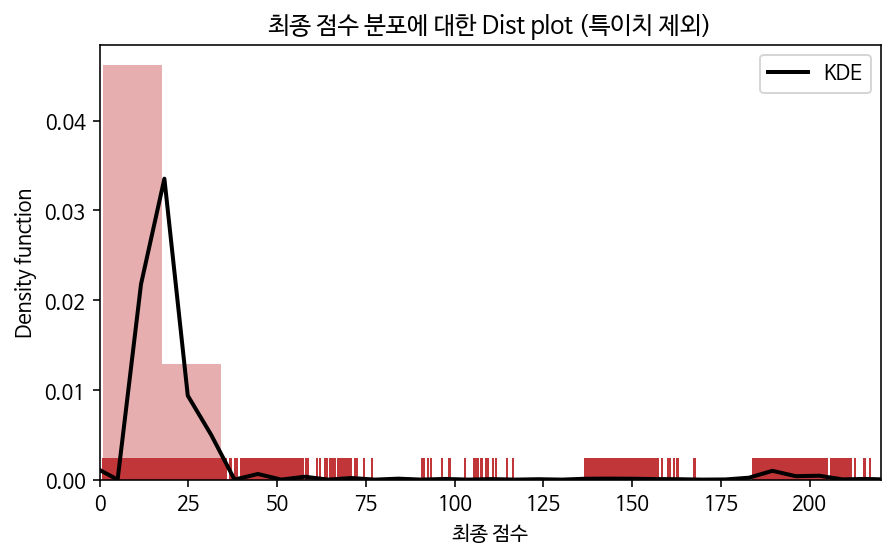

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(7,4)
sns.distplot(seongdong_score_wtd['final_score'], kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},rug=True, ax=ax)
ax.set(title="최종 점수 분포에 대한 Dist plot (특이치 제외)",xlabel="최종 점수",ylabel="Density function")
plt.xlim(left = 0, right=220)
plt.show()

집단감염이 집중적으로 발생하고 있는 몇몇 카테고리를 제외하면, 대부분 최종점수는 유동인구의 영향을 받아 0점~50점 사이에 집중적으로 분포하고있는 것을 확인할 수 있습니다.

다음부터 보여드릴 내용은 대표적인 다중이용시설에 대한 평가 결과입니다. 

#### 2.3.1 종교시설
유동인구에 따라 조금 차이는 있겠지만 종교시설은 100점~200점, 특수 카테고리 (종교,임시)는 신천지로 인해 800점의 점수를 기록해 아주 위험한 것으로 평가되었습니다.

In [ ]:
seongdong_score_wtd[seongdong_score_wtd['상권업종중분류코드']=='M01'].sample(2)

,상호명,상권업종중분류코드,상권업종소분류코드,상권업종중분류명,상권업종소분류명,행정동명,위도,경도,bot_cat_score,mid_cat_score,fp_score,final_score,time,fillColor
230090,열방제자교회,M01,M01A01,0,0,금호2.3가동,37.548886643,127.016437346,48.52885,134.479684,2.858596,185.86713,2020-03-03 02:00:00,#eb0e0e
229565,시온성교회,M01,M01A01,0,0,응봉동,37.54881326,127.031474285,48.52885,134.479684,2.665086,185.67362,2020-03-03 05:00:00,#eb0e0e


M01A00 종교, 임시 - 평균 808점

In [ ]:
seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='M01A00'].sample(2)

,상호명,상권업종중분류코드,상권업종소분류코드,상권업종중분류명,상권업종소분류명,행정동명,위도,경도,bot_cat_score,mid_cat_score,fp_score,final_score,time,fillColor
232446,천리교,M01,M01A00,0,0,행당2동,37.560115548,127.030243771,663.991848,134.479684,3.404247,801.875779,2020-03-03 06:00:00,#eb0e0e
232438,여호와의증인,M01,M01A00,0,0,마장동,37.565910449,127.04523682,663.991848,134.479684,11.455034,809.926567,2020-03-03 22:00:00,#eb0e0e


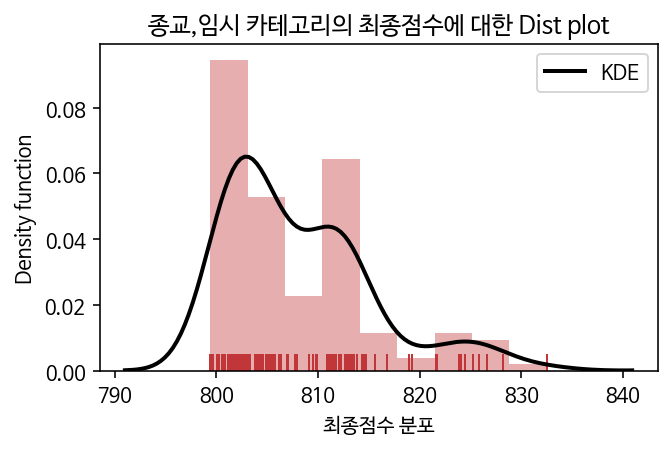

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(5,3)
sns.distplot(seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='M01A00']['final_score'],
             kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},rug=True, ax=ax)
ax.set(title="종교,임시 카테고리의 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
plt.show()

M01A01 기독교 -평균 193점

In [ ]:
seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='M01A01'].sample(2)

,상호명,상권업종중분류코드,상권업종소분류코드,상권업종중분류명,상권업종소분류명,행정동명,위도,경도,bot_cat_score,mid_cat_score,fp_score,final_score,time,fillColor
230163,선목교회,M01,M01A01,0,0,옥수동,37.540701597,127.012583649,48.52885,134.479684,3.735805,186.744339,2020-03-03 03:00:00,#eb0e0e
231566,재림마을(금호동교회),M01,M01A01,0,0,금호4가동,37.547672857,127.024399998,48.52885,134.479684,7.613527,190.622061,2020-03-03 14:00:00,#eb0e0e


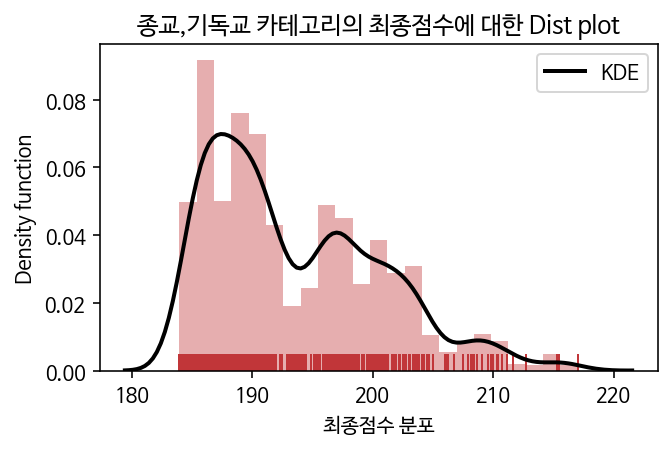

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(5,3)
sns.distplot(seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='M01A01']['final_score'],
             kde=True, rug=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},ax=ax)
ax.set(title="종교,기독교 카테고리의 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
plt.show()

M01A02 불교 - 평균 148점

In [ ]:
seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='M01A02'].sample(2)

,상호명,상권업종중분류코드,상권업종소분류코드,상권업종중분류명,상권업종소분류명,행정동명,위도,경도,bot_cat_score,mid_cat_score,fp_score,final_score,time,fillColor
232091,미타사(정수암),M01,M01A02,0,0,옥수동,37.543858719,127.017398854,0.636862,134.479684,18.663408,153.779953,2020-03-03 11:00:00,#eb0e0e
231991,미타사(금보암),M01,M01A02,0,0,옥수동,37.543858719,127.017398854,0.636862,134.479684,24.870274,159.986820,2020-03-03 07:00:00,#eb0e0e


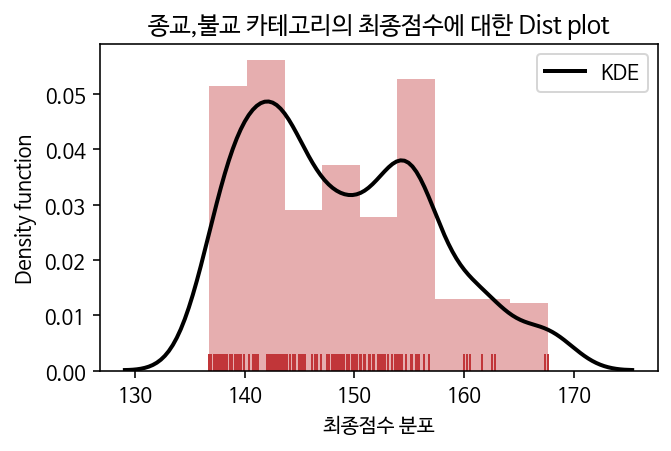

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(5,3)
sns.distplot(seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='M01A02']['final_score'],
             kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},rug=True, ax=ax)
ax.set(title="종교,불교 카테고리의 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
plt.show()

M01A03 천주교 - 평균 146점

In [ ]:
seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='M01A03'].sample(2)

,상호명,상권업종중분류코드,상권업종소분류코드,상권업종중분류명,상권업종소분류명,행정동명,위도,경도,bot_cat_score,mid_cat_score,fp_score,final_score,time,fillColor
232229,마장동성당,M01,M01A03,0,0,마장동,37.566579621,127.042914772,0.764234,134.479684,5.291524,140.535442,2020-03-03 05:00:00,#eb0e0e
232270,행당동성당,M01,M01A03,0,0,행당2동,37.55559246,127.032045441,0.764234,134.479684,5.851147,141.095065,2020-03-03 22:00:00,#eb0e0e


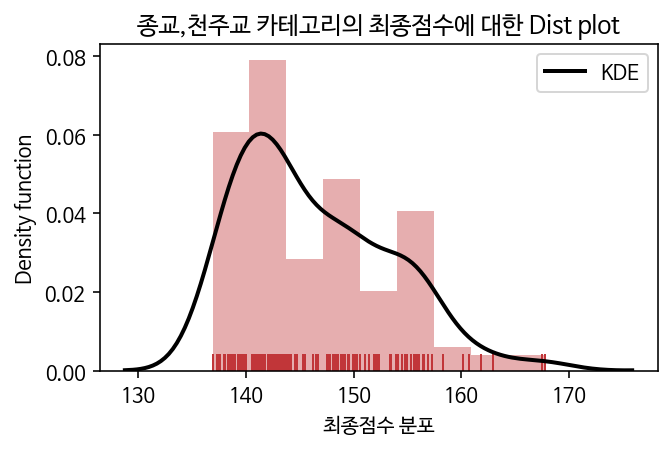

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(5,3)
sns.distplot(seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='M01A03']['final_score'], 
             kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},rug=True, ax=ax)
ax.set(title="종교,천주교 카테고리의 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
plt.show()

####2.3.2 병원
병원의 경우 40점~65점, 평균 57점의 점수를 기록했습니다.


In [ ]:
seongdong_score_wtd[seongdong_score_wtd['상권업종중분류코드']=='S01'].sample(2)

,상호명,상권업종중분류코드,상권업종소분류코드,상권업종중분류명,상권업종소분류명,행정동명,위도,경도,bot_cat_score,mid_cat_score,fp_score,final_score,time,fillColor
228371,서울연세병원,S01,S01B02,0,0,행당1동,37.5606,127.036,0.0,40.402496,13.451147,53.853644,2020-03-03 11:00:00,#ff5e00
228411,연세바로척병원,S01,S01B02,0,0,성수2가3동,37.5444,127.065,0.0,40.402496,2.288818,42.691315,2020-03-03 03:00:00,#ff833b


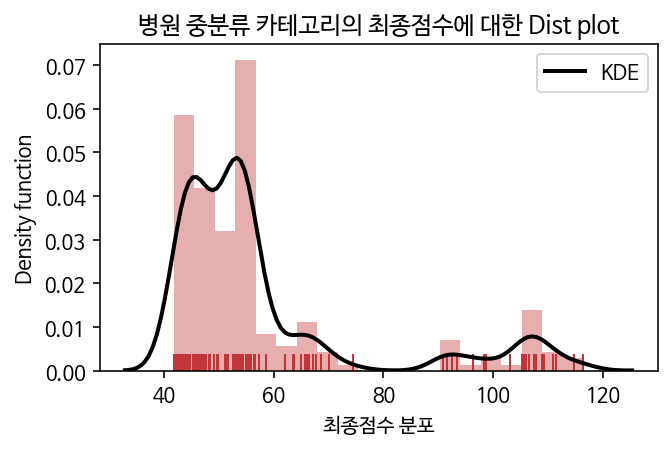

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(5,3)
sns.distplot(seongdong_score_wtd[seongdong_score_wtd['상권업종중분류코드']=='S01']['final_score'],
             kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},rug=True, ax=ax)
ax.set(title="병원 중분류 카테고리의 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
plt.show()

####2.3.3 탁구장
탁구장의 경우 10점~30점, 평균 18점의 점수를 기록했습니다.

In [ ]:
seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='N01A05'].sample(2)

,상호명,상권업종중분류코드,상권업종소분류코드,상권업종중분류명,상권업종소분류명,행정동명,위도,경도,bot_cat_score,mid_cat_score,fp_score,final_score,time,fillColor
162966,탁구탁구,N01,N01A05,PC/오락/당구/볼링등,탁구장,왕십리2동,37.564,127.03,9.043434,0.904343,1.596866,11.544644,2020-03-03 06:00:00,#c9ff66
162933,세종탁구장,N01,N01A05,PC/오락/당구/볼링등,탁구장,용답동,37.5607,127.067,9.043434,0.904343,10.813322,20.761099,2020-03-03 21:00:00,#ffe74d


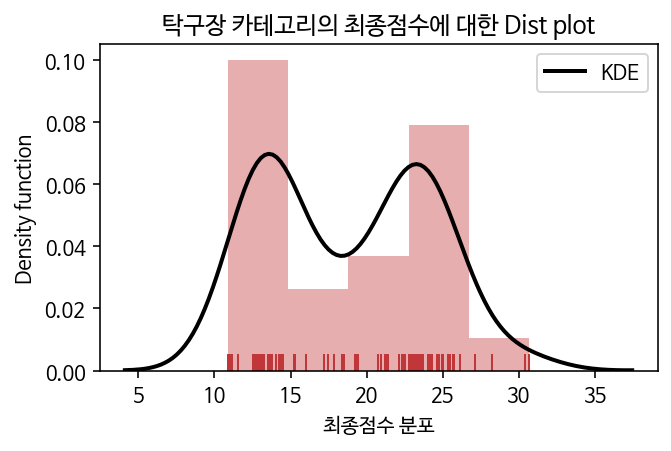

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(5,3)
sns.distplot(seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='N01A05']['final_score'], 
             kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},rug=True, ax=ax)
ax.set(title="탁구장 카테고리의 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
plt.show()

####2.3.4 노래방
노래방의 경우에도 10~30점, 평균16점의 점수를 보였습니다.

In [ ]:
seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='N02A01'].sample(2)

,상호명,상권업종중분류코드,상권업종소분류코드,상권업종중분류명,상권업종소분류명,행정동명,위도,경도,bot_cat_score,mid_cat_score,fp_score,final_score,time,fillColor
192324,서울숲노래방,N02,N02A01,무도/유흥/가무,노래방,성수1가2동,37.5466,127.045,0.891606,3.54095,18.701301,23.133858,2020-03-03 12:00:00,#ffe74d
194465,민트,N02,N02A01,무도/유흥/가무,노래방,성수2가3동,37.5459,127.054,0.891606,3.54095,28.163493,32.596050,2020-03-03 17:00:00,#ffaf38


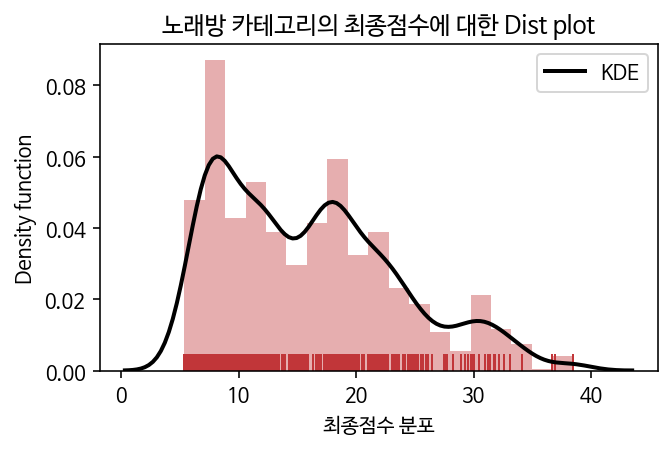

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(5,3)
sns.distplot(seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='N02A01']['final_score'], 
             kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},rug=True, ax=ax)
ax.set(title="노래방 카테고리의 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
plt.show()

####2.3.5 헬스장
헬스장의 경우 20~40점, 평균 26점의 점수를 기록했습니다.

In [ ]:
seongdong_score_wtd[seongdong_score_wtd['상권업종중분류코드']=='P02'].sample(n=2)

,상호명,상권업종중분류코드,상권업종소분류코드,상권업종중분류명,상권업종소분류명,행정동명,위도,경도,bot_cat_score,mid_cat_score,fp_score,final_score,time,fillColor
227970,피트니스에이치,P02,P02A13,실내운동시설,헬스클럽,송정동,37.5559,127.071,14.138326,2.827665,6.330548,23.296540,2020-03-03 18:00:00,#ffe74d
228039,레이휘트니스몰,P02,P02A13,실내운동시설,헬스클럽,행당1동,37.558,127.039,14.138326,2.827665,14.901164,31.867156,2020-03-03 15:00:00,#ffaf38


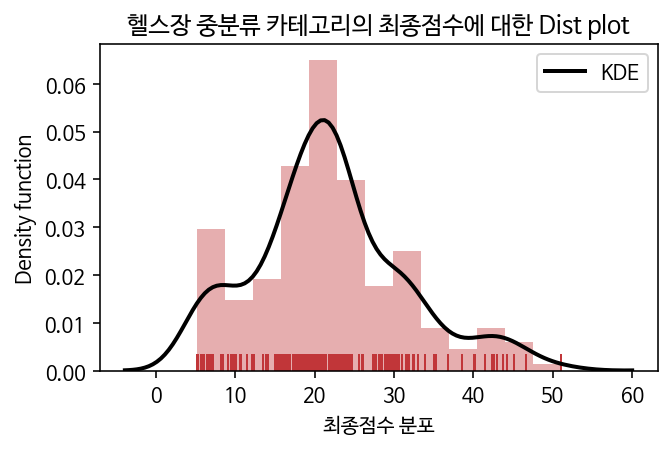

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(5,3)
sns.distplot(seongdong_score_wtd[seongdong_score_wtd['상권업종중분류코드']=='P02']['final_score'],
             kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"}, rug=True, ax=ax)
ax.set(title="헬스장 중분류 카테고리의 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
plt.show()

####2.3.6 대중목욕탕
목욕탕의 경우 0~25점, 평균 10점 기록하고 있습니다. 

목욕탕의 경우 현재 코로나 데이터에서는 감염 사례가 없기 때문에, 유동인구 점수만 반영되고 있습니다.

In [ ]:
seongdong_score_wtd[seongdong_score_wtd['상권업종중분류코드']=='F09'].sample(2)

,상호명,상권업종중분류코드,상권업종소분류코드,상권업종중분류명,상권업종소분류명,행정동명,위도,경도,bot_cat_score,mid_cat_score,fp_score,final_score,time,fillColor
221939,한신옥사우나내이용실,F09,F09A02,대중목욕탕/휴게,사우나/증기탕/온천,왕십리2동,37.563,127.028,0.0,0.0,3.602979,3.602979,2020-03-03 11:00:00,#80ff66
221983,설악대중사우나,F09,F09A02,대중목욕탕/휴게,사우나/증기탕/온천,용답동,37.5607,127.068,0.0,0.0,11.226781,11.226781,2020-03-03 07:00:00,#c9ff66


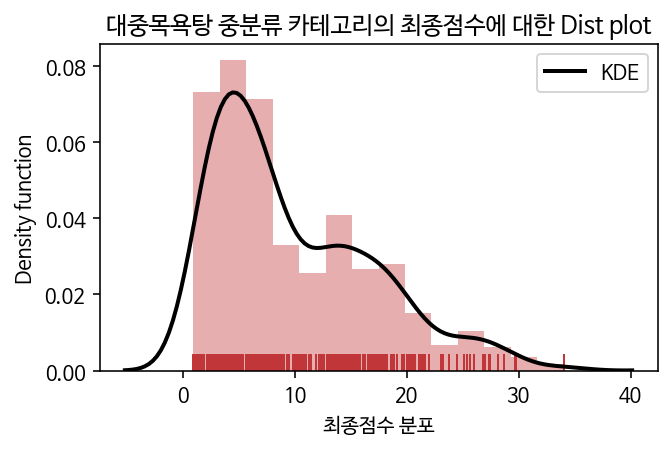

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(5,3)
sns.distplot(seongdong_score_wtd[seongdong_score_wtd['상권업종중분류코드']=='F09']['final_score'],
             kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},rug=True, ax=ax)
ax.set(title="대중목욕탕 중분류 카테고리의 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
plt.show()

####2.3.7 카페
카페 역시 약 0~25점, 평균 13점으로 평가되었습니다. 

In [ ]:
seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='Q12A01'].sample(2)

,상호명,상권업종중분류코드,상권업종소분류코드,상권업종중분류명,상권업종소분류명,행정동명,위도,경도,bot_cat_score,mid_cat_score,fp_score,final_score,time,fillColor
116633,본헤드커피컴퍼니,Q12,Q12A01,커피점/카페,커피전문점/카페/다방,옥수동,37.5428,127.018,0.382117,0.038212,25.434144,25.854472,2020-03-03 17:00:00,#ffd34d
116285,커피베이금호래미안하이리버점,Q12,Q12A01,커피점/카페,커피전문점/카페/다방,금호2.3가동,37.5522,127.024,0.382117,0.038212,2.680925,3.101253,2020-03-03 05:00:00,#80ff66


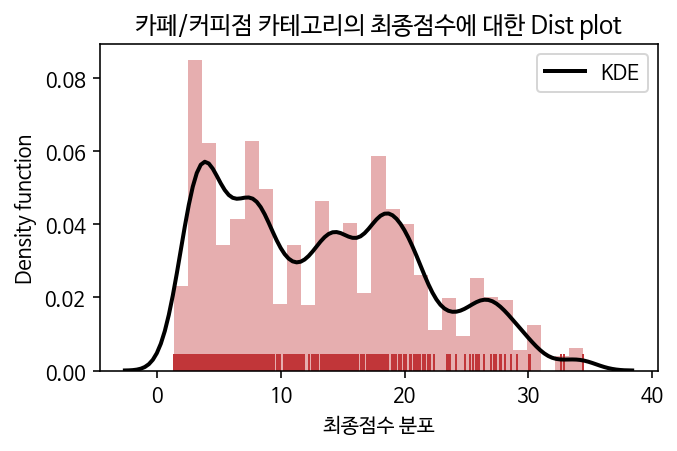

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(5,3)
sns.distplot(seongdong_score_wtd[seongdong_score_wtd['상권업종소분류코드']=='Q12A01']['final_score'],
             kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},rug=True, ax=ax)
ax.set(title="카페/커피점 카테고리의 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
plt.show()

참고로 시간대별로는 다음과 같은 분포를 보였습니다.

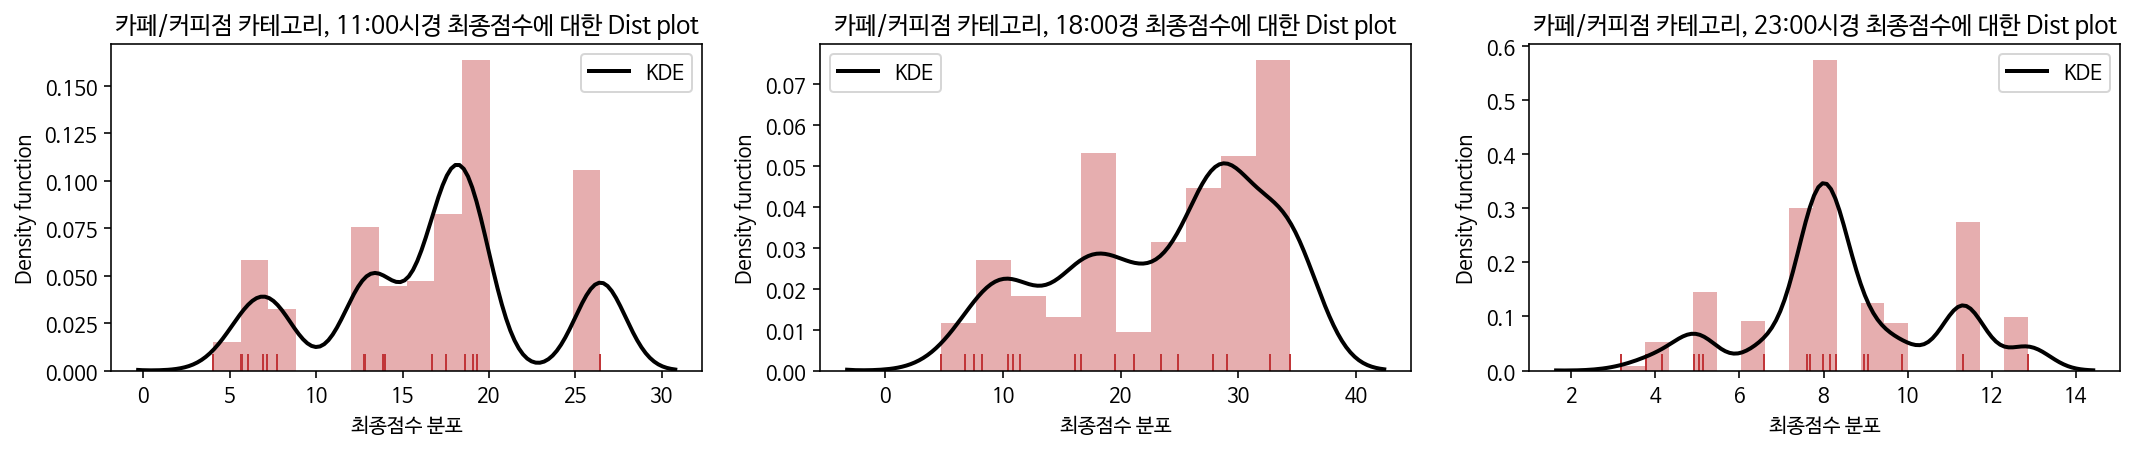

In [ ]:
figure, (ax,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,3)
sns.distplot(seongdong_score_wtd[(seongdong_score_wtd['상권업종소분류코드']=='Q12A01')&(seongdong_score_wtd['time']=='2020-03-03 18:00')]['final_score'], 
             kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"},rug=True, ax=ax2)
ax2.set(title="카페/커피점 카테고리, 18:00경 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
sns.distplot(seongdong_score_wtd[(seongdong_score_wtd['상권업종소분류코드']=='Q12A01')&(seongdong_score_wtd['time']=='2020-03-03 23:00')]['final_score'], 
             kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"}, rug=True, ax=ax3)
ax3.set(title="카페/커피점 카테고리, 23:00시경 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
sns.distplot(seongdong_score_wtd[(seongdong_score_wtd['상권업종소분류코드']=='Q12A01')&(seongdong_score_wtd['time']=='2020-03-03 11:00')]['final_score'], 
             kde=True, kde_kws={"color": "k", "lw": 2, "label": "KDE"}, rug=True, ax=ax)
ax.set(title="카페/커피점 카테고리, 11:00시경 최종점수에 대한 Dist plot",xlabel="최종점수 분포",ylabel="Density function")
plt.show()

### 2.4 안전도 시각화
산출한 안전도를 시간대별로 지도에 시각화해보았습니다.

In [ ]:
#timestamped json data 생성 함수
def create_geojson_features (df):
    features = []
    
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry' : {
                'type':'Point',
                'coordinates':[float(row['경도']),float(row['위도'])]
            },
            'properties': {
                'time' : pd.to_datetime(row['time'],unit='h').__str__(),
                'style' : {'color':''},
                'icon' : 'circle',
                'iconstyle':{
                    'fillColor': row['fillColor'],
                    'fillOpacity': 0.9,
                    'stroke' : 'true',
                    'radius': 2
                }
            }
        }
        features.append(feature)
    return features

In [ ]:
score_map_wnh = create_geojson_features(wnh)

In [ ]:
m = folium.Map(location = [37.56310, 127.03350],tiles = 'cartodbpositron',zoom_start = 15)
#legend 수동으로 추가
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#eb0e0e;font-size: 70%;'>over140</span><span style='background:#ff2600;font-size: 70%;'>over120</span><span style='background:#ff3000;font-size: 70%;'>over100</span><span style='background:#ff3500;font-size: 70%;'>over80
    </span><span style='background:#ff4000;font-size: 70%;'>over60</span><span style='background:#ff5e00;font-size: 70%;'>over50</span><span style='background:#ff833b;font-size: 70%;'>over40</span><span style='background:#ffa069;font-size: 70%;'>over35</span><span style='background:#ffaf38;font-size: 70%;'>over30</span>
    <span style='background:#ffd34d;font-size: 70%;'>over25</span><span style='background:#ffe74d;font-size: 70%;'>over20</span><span style='background:#ebff66;font-size: 70%;'>over15</span><span style='background:#c9ff66;font-size: 70%;'>over10</span>
    <span style='background:#a8ff66;font-size: 70%;'>over5</span><span style='background:#80ff66;font-size: 70%;'>over0</span>
    </li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)
m.get_root().add_child(macro)

plugins.TimestampedGeoJson(score_map_wnh,
                           period = 'PT1H',
                           duration = 'PT1M',
                           transition_time = 100,
                           auto_play = True).add_to(m)

m

대부분의 종교시설은 빨갛게 (위험하게) 표시되었고, 유동인구 정보가 '50m'단위가 아닌 '동별' 데이터이기 때문에, 시간에 따라 동별로 위험도가 변화하고 있는 것을 확인할 수 있습니다. 그렇지만 40점 점수구간까지는 5점단위로 구간을 두었고, 그렇기 때문에 확진자가 주로 나와서 소분류 점수/중분류 점수를 가진 장소와 그렇지 않고 유동인구점수에만 영향을 받는 장소는 1~2단계 이상의 차이가 나기 때문에 구분될 수 있습니다.   

## Application 1: 안전도 길 찾기
안전도를 활용한 application으로 길 찾기를 생각해볼 수 있습니다. 

간단하게는 가장 안전한 길을 안내할 수도 있겠지만, 최단 경로 찾기 문제에서 weight를 거리가 아닌 안전도로 사용한다면 무의미하게 아주 빙 돌아서 가는 길을 제안할 것입니다.

따라서 저희는 가장 빠른길 n개를 찾아서, 각 경로의 node별로 25m이내의 건물의 안전도를 모두 더해 node별 안전도를 계산하고 이를 시각화해, 사용자로 하여금 조금 더 안전한 길을 선택하거나, 위험 건물군이 포집된 거리에서는 마스크를 '꼭' 쓸 수 있도록 해 안전한 이동을 유도하는 방법을 제안합니다.  

길찾기 알고리즘까지 직접 구현했으면 좋았겠지만, 사용하는 환경에서 서울시 수십만개의 node를 가지고 직접 구현하는데 어려움이 있어 부득이 CH알고리즘 기반의 OSRM Open API를 사용했습니다.
http://project-osrm.org/

OSRM is free, open source, and available under the very permissive (simplified) 2-clause BSD license.

In [ ]:
#길찾기 API
params = (
    ('overview', 'full'),('steps','false'),('alternatives','3'),('geometries', 'geojson')
) 

url = 'http://router.project-osrm.org/route/v1/foot/127.034875,37.562240;127.032960,37.564626'
response = requests.get(url, params=params)
response= response.json()

In [ ]:
cord =(((response['routes'])[0])['geometry']['coordinates'])        #첫 번째 루트
for each in np.arange(0,len(cord)):
    cord[each].reverse()
cord2 = (((response['routes'])[1])['geometry']['coordinates'])      #두 번째 루트
for each in np.arange(0,len(cord2)):
    cord2[each].reverse()
cord_df = pd.DataFrame(cord,columns=['lat','lon'])                  #첫번째 루트 좌표
cord2_df = pd.DataFrame(cord2,columns=['lat','lon'])                #두번째 루트 좌표

In [ ]:
#시각화및 유동인구점수를 위한 처리
cord_df['time'] = datetime.datetime(2020, 3, 3, hour=0, minute = 0)
cords_df = cord_df.loc[cord_df.index.repeat(24)].copy()
cords_df = cords_df.reset_index(drop=True)
cords_df_d = cords_df.to_dict()
#임의의 날짜 (3월3일) 을 고름
start = datetime.datetime(2020, 3, 3, hour=0, minute = 0)
end = datetime.datetime(2020,3, 3, hour =23, minute = 0)
timeindex = pd.date_range(start, end, freq='H')
#시간 처리
for i in range(0,len(cords_df_d['time'])):
    cords_df_d['time'][i] = timeindex[i%24]
cords_df = pd.DataFrame(cords_df_d)

In [ ]:
#시각화및 유동인구점수를 위한 처리
cord2_df['time'] = datetime.datetime(2020, 3, 3, hour=0, minute = 0)
cords2_df = cord2_df.loc[cord2_df.index.repeat(24)].copy()
cords2_df = cords2_df.reset_index(drop=True)
cords2_df_d = cords2_df.to_dict()
for i in range(0,len(cords2_df_d['time'])):
    cords2_df_d['time'][i] = timeindex[i%24]
cords2_df = pd.DataFrame(cords2_df_d)

In [ ]:
#각 노드에 대한 안전도 계산
for index in tqdm(cords_df.index):
    node_score = 0
    t_lat = float(cords_df['lat'][index])
    t_lon = float(cords_df['lon'][index])
    t_coord = [t_lat, t_lon]
    time = cords_df['time'][index]
    tmp = wnh[wnh['time'] == time]
    for k in tmp.index:
        lat = float(wnh['위도'][k])
        lon = float(wnh['경도'][k])
        coord = [lat,lon]
        d = haversine(t_coord, coord, unit='m')
        if d < 25:
            node_score += wnh['final_score'][k]
        else:
            continue
    cords_df.loc[index,'node_score'] = node_score

100%|██████████| 432/432 [00:29<00:00, 14.88it/s]


In [ ]:
for index in tqdm(cords2_df.index):
    node_score = 0
    t_lat = float(cords2_df['lat'][index])
    t_lon = float(cords2_df['lon'][index])
    t_coord = [t_lat, t_lon]
    time = cords2_df['time'][index]
    tmp = wnh[wnh['time'] == time]
    for k in tmp.index:
        lat = float(wnh['위도'][k])
        lon = float(wnh['경도'][k])
        coord = [lat,lon]
        d = haversine(t_coord, coord, unit='m')
        if d < 25:
            node_score += wnh['final_score'][k]
        else:
            continue
    cords2_df.loc[index,'node_score'] = node_score

100%|██████████| 312/312 [00:21<00:00, 14.72it/s]


In [ ]:
def fillcolor(df):
    df['fillColor'] = '#ff0800'
    df.loc[df['node_score']<300 , 'fillColor'] = '#ff2600'
    df.loc[df['node_score']<250 , 'fillColor'] = '#ff5e00'
    df.loc[df['node_score']<200 , 'fillColor'] = '#ff7300'
    df.loc[df['node_score']<150 , 'fillColor'] = '#ff9900'
    df.loc[df['node_score']<100 , 'fillColor'] = '#ffd54d'
    df.loc[df['node_score']<50 , 'fillColor'] = '#ffe74d'
    df.loc[df['node_score']<25 , 'fillColor'] = '#e5ff66'
    df.loc[df['node_score']<15 , 'fillColor'] = '#b5ff66'
    df.loc[df['node_score']<5 , 'fillColor'] = '#36ff3c'
        
fillcolor(cords_df)
fillcolor(cords2_df)


In [ ]:
#json data 생성 함수
def create_line(df):
    lines = []
    for index in range(0,len(df.index)-24):
        line={
            'coordinates':[
                           [df.loc[index,'lon'],df.loc[index,'lat']],
                           [df.loc[index+24,'lon'],df.loc[index+24,'lat']]
            ],
            'dates':[str(df.loc[index,'time']),str(df.loc[index+24,'time'])],
            'color': df.loc[index,'fillColor']
        }
        lines.append(line)

    return lines

lines = create_line(cords_df)
lines2 = create_line(cords2_df)

In [ ]:
#route1
features = [ 
            { 
                'type': 'Feature', 
             'geometry': { 
                 'type': 'LineString', 
                 'coordinates': line['coordinates'], 
                 }, 
             'properties': { 
                 'times': line['dates'], 
                 'style': { 
                     'color': line['color'],  
                     } 
                 } 
             } for line in lines 
            ]
#route2
features2 = [ 
            { 
                'type': 'Feature', 
             'geometry': { 
                 'type': 'LineString', 
                 'coordinates': line['coordinates'], 
                 }, 
             'properties': { 
                 'times': line['dates'], 
                 'style': { 
                     'color': line['color'],  
                     } 
                 } 
             } for line in lines2
            ]

In [ ]:
m= folium.Map(location=[37.56310, 127.03350], tiles = 'cartodbpositron',zoom_start=17)
#route1
plugins.TimestampedGeoJson({'type': 'FeatureCollection', 'features': features }, 
                           period='PT1H',
                           duration = 'PT1M',
                           transition_time = 100,
                           auto_play = False,
                           add_last_point=False).add_to(m)
#route2
plugins.TimestampedGeoJson({'type': 'FeatureCollection', 'features': features2 }, 
                           period='PT1H',
                           duration = 'PT1M',
                           transition_time = 100,
                           auto_play = False,
                           add_last_point=False).add_to(m)

#좌표표시
plugins.MousePosition().add_to(m)

#출발지점/도착지점 표식 
for i in np.arange(0,len(cord2)):
    if i == 0:
        folium.Marker(cord2[i],popup='Starting Point', icon=folium.Icon(icon='star',color='blue')).add_to(m)
    elif i == len(cord2)-1:
        folium.Marker(cord2[i],popup='Target Point', icon=folium.Icon(icon='flag',color='blue')).add_to(m)

#위에서 구했던 위험도 
plugins.TimestampedGeoJson(score_map_wnh,
                           period = 'PT1H',
                           duration = 'PT1M',
                           transition_time = 100,
                           auto_play = False).add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

위와같이 출발지 (별 표시)에서 목표지(깃발 표시) 까지 가는 경로를 2개 표시해주고, 경로상에 안전도를 표시해준다면, 사용자는 조금 더 안전한 경로로 우회해서 가거나, 우회하지 않더라도 그 경로상에 경각심을 주어 마스크를 잘 착용할 수 있도록 유도할 수 있을 것입니다.

## Application 2: 안전도 기반 장소추천
안전도를 기반으로 사용자에게 안전도가 높은 지역 (즉, 유동인구가 적고 감염이 발생하지 않은 카테고리)의 장소를 추천할 수 있습니다.

예를 들어 현재시각이 2020년 3월 3일 19:00 일 때, 한식집에 가고자 한다면 다음과 같이 추천을 받을 수 있을 것입니다.

코로나가 지속적으로 반복해서 발생하는 몇몇 카테고리를 제외하면, 대부분은 유동인구 점수의 영향을 많이 받게됩니다. 따라서 점수가 낮은 곳으로 - 즉, 유동인구가 적어진 곳으로 사용자들을 유도할 수 있다면, 유동인구가 사라져 힘들어진 상권도 살리고, 코로나 집단감염도 예방하는 두 가지 효과를 얻을 수 있을것이라고 생각합니다. 

In [ ]:
seongdong_score_wtd[(seongdong_score_wtd['상권업종중분류명']=='한식') & (seongdong_score_wtd['time']=='2020-03-03 19:00:00')].sort_values(by=['final_score'], axis=0)

,상호명,상권업종중분류코드,상권업종소분류코드,상권업종중분류명,상권업종소분류명,행정동명,위도,경도,bot_cat_score,mid_cat_score,fp_score,final_score,time,fillColor
27571,59년왕십리곱창,Q01,Q01A01,한식,한식/백반/한정식,왕십리2동,37.5614,127.031,0.0,0.0,4.379812,4.379812,2020-03-03 19:00:00,#80ff66
30307,삼미식당,Q01,Q01A01,한식,한식/백반/한정식,왕십리2동,37.5608,127.024,0.0,0.0,4.379812,4.379812,2020-03-03 19:00:00,#80ff66
30259,마루곱창,Q01,Q01A01,한식,한식/백반/한정식,왕십리2동,37.5635,127.03,0.0,0.0,4.379812,4.379812,2020-03-03 19:00:00,#80ff66
26539,안방,Q01,Q01A01,한식,한식/백반/한정식,왕십리2동,37.5608,127.03,0.0,0.0,4.379812,4.379812,2020-03-03 19:00:00,#80ff66
30019,기분좋은한잔,Q01,Q01A01,한식,한식/백반/한정식,왕십리2동,37.5614,127.031,0.0,0.0,4.379812,4.379812,2020-03-03 19:00:00,#80ff66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40963,한촌설렁탕옥수역점,Q01,Q01A09,한식,설렁탕집,옥수동,37.5418,127.018,0.0,0.0,27.725908,27.725908,2020-03-03 19:00:00,#ffd34d
26251,구쁘,Q01,Q01A01,한식,한식/백반/한정식,옥수동,37.5409,127.015,0.0,0.0,27.725908,27.725908,2020-03-03 19:00:00,#ffd34d
25147,제주생고깃간,Q01,Q01A01,한식,한식/백반/한정식,옥수동,37.5425,127.016,0.0,0.0,27.725908,27.725908,2020-03-03 19:00:00,#ffd34d
31387,락엔웍,Q01,Q01A01,한식,한식/백반/한정식,옥수동,37.5443,127.015,0.0,0.0,27.725908,27.725908,2020-03-03 19:00:00,#ffd34d


## 결론
1. 코로나 집단감염은 집단 감염이 발생했던 건물의 카테고리와 유사한 카테고리에서 감염이 번져나가는 것을 확인할 수 있었습니다.
2. 따라서 저희는 카테고리를 기반으로 점수를 계산했습니다..
3. 산출한 안전도를 가지고 길찾기, 장소추천등의 Application을 이용해 국민의 안전한 이동을 도울 수 있을 것입니다. 
4. 추후 지하철과 버스 등의 대중교통시설에도 이와 동일하게 유동인구 점수를 이용하면 안전도 산출이 가능할 것입니다. (지하철, 버스등을 대중교통 중분류로 묶고, 각각을 소분류로 분류하여 해당 시설에서 집단감염 발생시 카테고리 점수도 산출 가능합니다) 

저희가 이번 분석에서 갖는 한계점은 다음과 같습니다.
* 한계점 

    1. 사용한 소상공인진흥공단 데이터가 누락된 부분이 많아 예시 시각화에서 안전도가 완전히 정확하지는 못합니다. 지역의 상점 / 건물들에 대한 좌표(혹은 주소),분류에 대한 데이터가 없다면 위 아이디어는 사용할 수 없습니다. 또, 데이터가 부정확하다면 안전도의 신뢰도역시 같이 하락합니다.
    2. 사용한 유동인구 데이터가 50m단위 데이터가 아닌, 동단위 데이터이기 때문에 부정확합니다. 50m 단위 데이터를 사용할 수 있다면 더 정확할 것입니다.
    3. 코로나 데이터또한 6월까지의 데이터이기 때문에, 코로나가 급속하게 다시 확산되고 있는 현재와 차이가 남. 데이터를 갱신해주면 더욱 정확해질 것입니다.
    4. 저희의 작업은 코로나 상황을 '평가'하는 모델링을 만드는 것이었습니다. 앞으로의 상황을 '예측'할수는 없습니다.
    5. 콜센터와 같이 분류가 애매한 카테고리가 있을 수 있습니다. 콜센터는 보험회사, 홈쇼핑 등 회사들에서 가지고 있지만 이 회사들은 따로 콜센터로 신고되어있지는 않기 때문입니다. (저희가 제대로 모르는 부분일 수도 있습니다. 콜센터 분류가 되어있는 장소를 찾기 어려웠습니다.)

본 저작물의 저작권은 Apache License v2.0을 따릅니다